In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram

from tracefc.io.session_directory import get_session_dir

In [2]:
# Define a class for a typical recording or set of recordings
from neuropy.core.session import ProcessData
    
def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
animal, sess_name = 'Han', 'training'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 12444.12 seconds 
duration: 3.46 hours 



# Preprocess Ephys data
Identify artifacts:  
- disconnects  
- filtering  
  
Send to event files to check in Neuroscope  
Write `dead_times.txt` file for spyking-circus and `artifacts.npy` file for my own analysis.

### Identify disconnect and motion artifacts

In [5]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=26), thresh=8, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()

Existing artifact epochs file loaded
Total artifact time = 109.1 seconds


start        stop label  duration
0     159.7436    170.1324  None   10.3888
1     408.2588    417.1892  None    8.9304
2     859.7700    861.2836  None    1.5136
3    1131.6012   1133.1612  None    1.5600
4    1388.3636   1389.8148  None    1.4512
5    1428.2516   1440.1052  None   11.8536
6    1606.8492   1608.3668  None    1.5176
7    1857.1372   1858.7028  None    1.5656
8    2132.0428   2133.4652  None    1.4224
9    2508.8548   2516.5156  None    7.6608
10   2612.2948   2620.5260  None    8.2312
11   3701.5812   3711.3020  None    9.7208
12   6664.8132   6673.4100  None    8.5968
13   7147.4852   7156.2684  None    8.7832
14   9819.1000   9827.1764  None    8.0764
15  11105.3740  11115.6836  None   10.3096
16  12436.8588  12444.3660  None    7.5072

/home/bowenw/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


<Axes: >

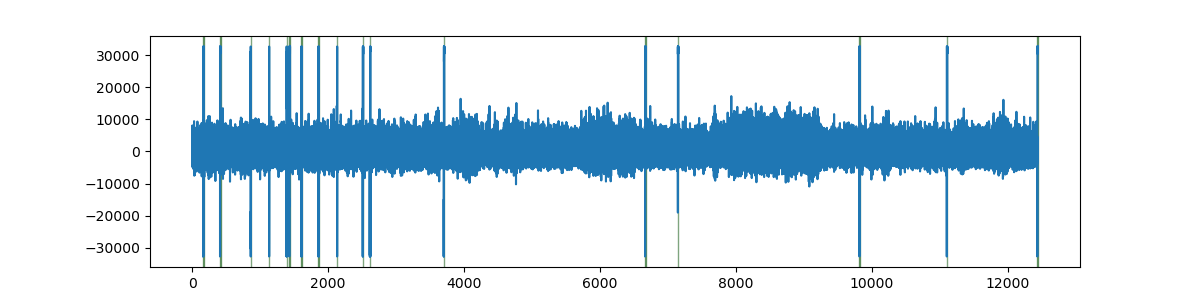

In [6]:
%matplotlib widget

chan_plot = 25
plot_signal_w_epochs(signal, chan_plot, art_epochs)

## Define probe group

/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training.probegroup.npy saved


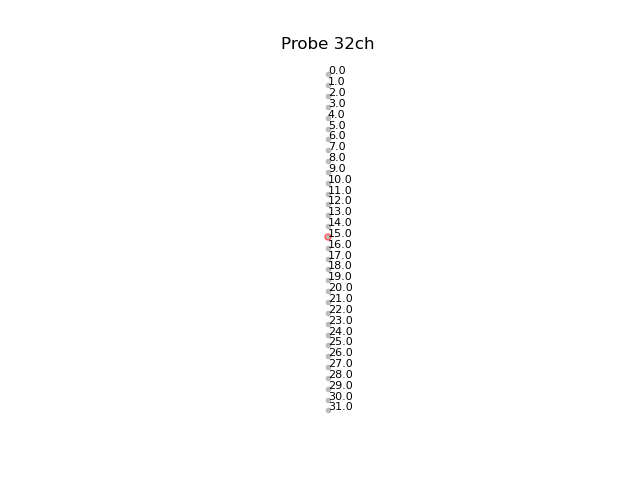

In [7]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=50, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

# Detect Theta epochs

In [8]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 8
# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
sess.recinfo.write_epochs(theta_epochs, ext='tha')
theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs.save(theta_epochs_file)

Best channel for theta: [8]
960 epochs remaining with durations within (1,20)
/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training.theta_epochs.npy saved


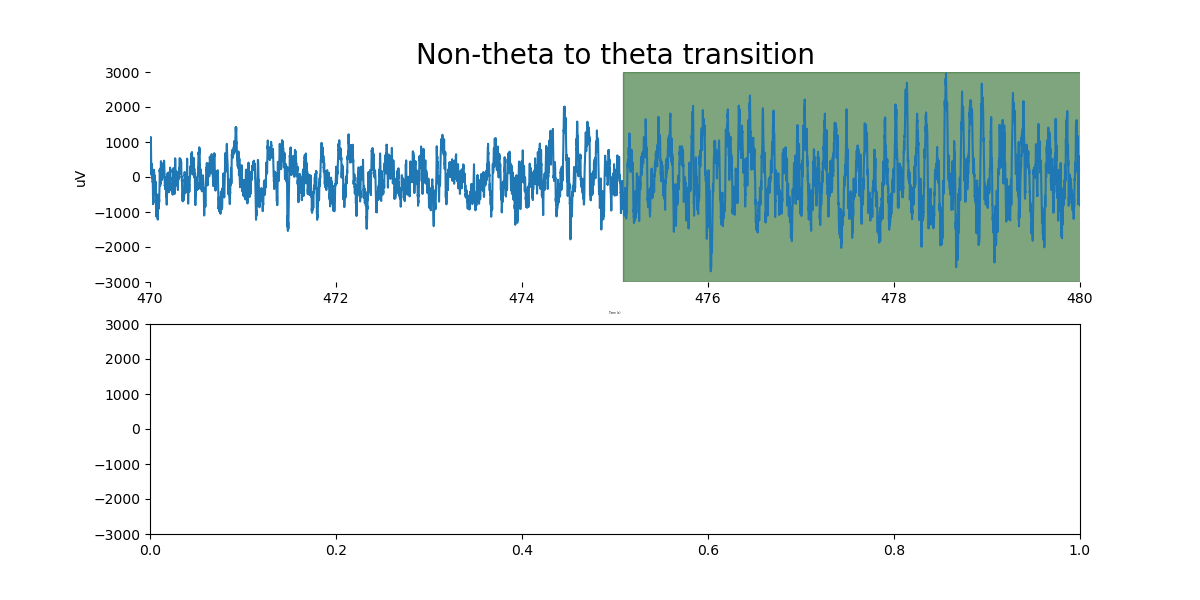

In [9]:
%matplotlib widget
fig, ax = plt.subplots(2, 1, sharex=False, sharey=True, figsize=(12, 6))
chan_plot = theta_channel
plot_signal_w_epochs(signal, chan_plot, theta_epochs, ax=ax[0])
# plot_signal_w_epochs(signal, chan_plot, art_epochs, ax=ax[1])

# Good example 2178 to 1282 seconds

# great theta starts at 475 seconds
# How to pretty up your plots

# 0) automatically zoom to right spot/limits
ax[0].set_xlim((470, 480))
ax[0].set_ylim((-3000, 3000))
# 1) remove top and right axes
sns.despine(ax=ax[0])
# 1a) (optional remove ALL axes)
sns.despine(ax=ax[0], left=True, bottom=True)
# 1b) Turn off ticks too
# ax[0].set_xticks([], minor=False)
# ax[0].set_yticks([], minor=False)
# 2) label axes
ax[0].set_xlabel('Time (s)', fontsize=2)
ax[0].set_ylabel('uV')
ax[0].set_title('Non-theta to theta transition', fontsize=20)
#3) Turn on xticks on top
ax[0].tick_params(axis='both', which='both')

(-4000.0, 4000.0)

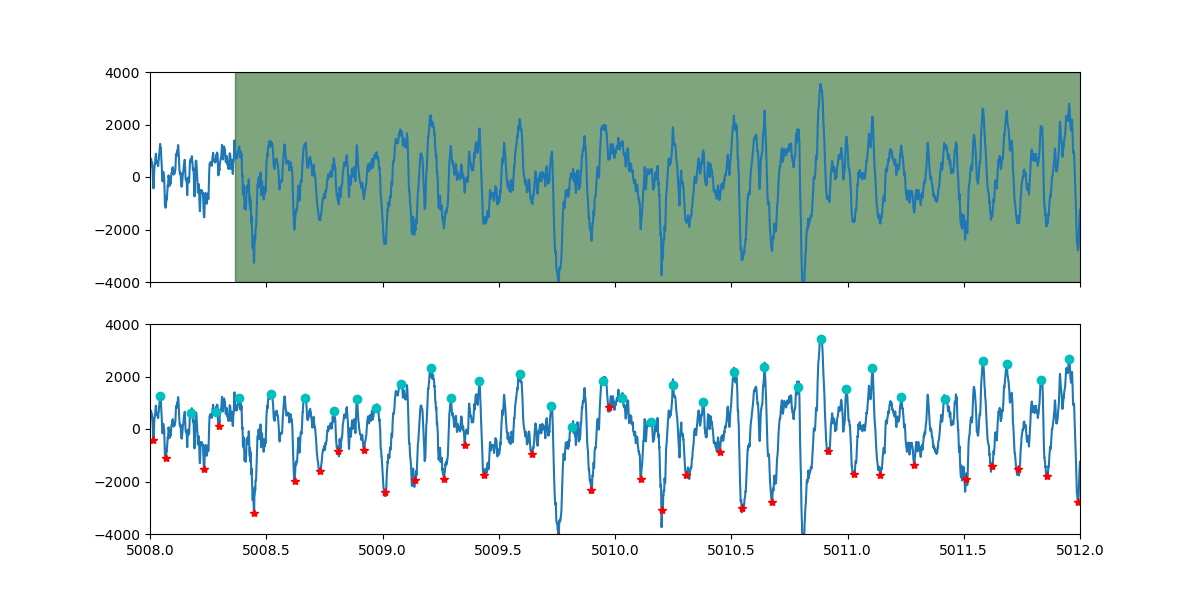

In [10]:
from neuropy.utils.signal_process import hilbert_amplitude_stat, theta_phase_specfic_extraction, ThetaParams
tparams = ThetaParams(lfp=signal.traces[theta_channel, :], fs=signal.sampling_rate, method="waveshape")
trough_indices = tparams.trough.astype(int)
peak_indices = tparams.peak.astype(int)
_, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True, sharey=True)
plot_signal_w_epochs(signal, chan_plot, theta_epochs, ax=ax[0])
ax[1].plot(signal.time, signal.traces[theta_channel])

ax[1].plot(signal.time[trough_indices], signal.traces[theta_channel, trough_indices], 'r*')
ax[1].plot(signal.time[peak_indices], signal.traces[theta_channel, peak_indices], 'co')

ax[0].set_xlim((5008,5012))
ax[1].set_ylim((-4000, 4000))

(-4000.0, 4000.0)

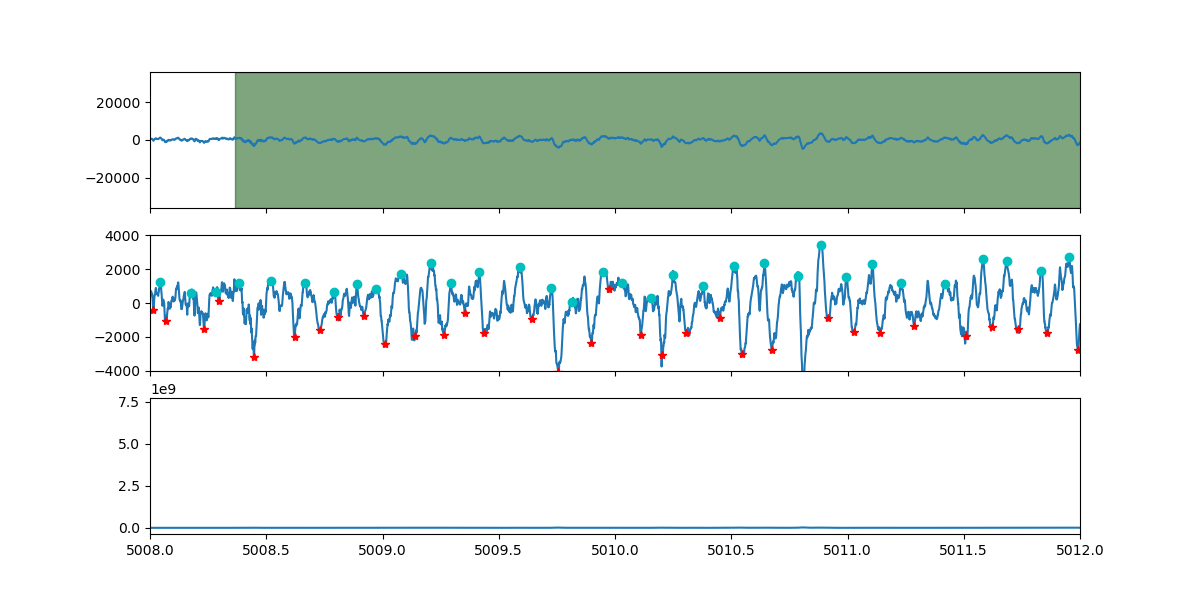

In [11]:
_, ax = plt.subplots(3, 1, figsize=(12, 6), sharex=True, sharey=False)
plot_signal_w_epochs(signal, chan_plot, theta_epochs, ax=ax[0])
ax[1].plot(signal.time, signal.traces[theta_channel])

ax[1].plot(signal.time[trough_indices], signal.traces[theta_channel, trough_indices], 'r*')
ax[1].plot(signal.time[peak_indices], signal.traces[theta_channel, peak_indices], 'co')

ax[2].plot(signal.time, tparams.amp)

ax[0].set_xlim((5008, 5012))
ax[1].set_ylim((-4000, 4000))

In [12]:
# Import USV epochs (from Sync_USV_and_Ephys notebook).
usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
usv_epochs = Epoch(epochs=None, file=usv_epochs_file)
usv_epochs

107 epochs
Snippet: 
         start        stop  Begin_Time   Freq_Min  Duration  Freq_Range  Score  \
0  446.819063  446.912341  446.819063  32.435751  0.093278   45.195929    1.0   
1  446.917153  446.991495  446.917153  50.405216  0.074342   34.441476    1.0   
2  447.052188  447.165813  447.052188  43.482818  0.113625   16.668958    1.0   
3  447.256451  447.308525  447.256451  46.914662  0.052074   11.521191    1.0   
4  447.305980  447.444434  447.305980  32.451890  0.138454    9.315006    1.0   

   Accept  nrec  t_start_eeg  t_stop_eeg label  
0       1     2   860.598041  860.691307        
1       1     2   860.696118  860.770450        
2       1     2   860.831136  860.944746        
3       1     2   861.035373  861.087440        
4       1     2   861.084896  861.223332        

In [13]:
t_start_eeg = usv_epochs._epochs.t_start_eeg
t_start_eeg

0       860.598041
1       860.696118
2       860.831136
3       861.035373
4       861.084896
          ...     
102    1624.587944
103    1625.300156
104    1625.886424
105    1626.619202
106    1858.644967
Name: t_start_eeg, Length: 107, dtype: float64

In [14]:
usv_epochs.start = t_start_eeg
usv_epochs.start

0       860.598041
1       860.696118
2       860.831136
3       861.035373
4       861.084896
          ...     
102    1624.587944
103    1625.300156
104    1625.886424
105    1626.619202
106    1858.644967
Name: t_start_eeg, Length: 107, dtype: float64

In [15]:
t_stop_eeg = usv_epochs._epochs.t_stop_eeg
t_stop_eeg

0       860.691307
1       860.770450
2       860.944746
3       861.087440
4       861.223332
          ...     
102    1625.214228
103    1625.794220
104    1626.518784
105    1627.160008
106    1858.734567
Name: t_stop_eeg, Length: 107, dtype: float64

In [16]:
usv_epochs.stop = t_stop_eeg
usv_epochs.stop

0       860.691307
1       860.770450
2       860.944746
3       861.087440
4       861.223332
          ...     
102    1625.214228
103    1625.794220
104    1626.518784
105    1627.160008
106    1858.734567
Name: t_stop_eeg, Length: 107, dtype: float64

In [17]:
usv_epochs.stops

array([ 446.91234103,  446.9914946 ,  447.16581265,  447.30852484,
        447.44443367,  447.84894862,  448.3436977 ,  449.061268  ,
        449.52330419,  449.811268  ,  450.141268  ,  450.75837922,
        452.01616364,  452.74485481,  453.561268  ,  453.85021666,
        453.94453525,  455.37710587,  455.49743658,  455.68825251,
        457.331268  ,  457.90817043,  459.251268  ,  459.46743658,
        460.40448923,  460.9052515 ,  462.47756898,  463.92805149,
        464.22724685,  464.86829524,  465.11413951,  465.441268  ,
        466.31478236,  467.20820857,  467.35800244,  468.32558768,
        468.91193674,  469.70262113,  470.80052919,  470.89377055,
        471.571268  ,  472.28334221,  473.58780087,  473.77469963,
        474.271268  ,  475.47178065,  476.30859897,  477.64173026,
        479.96264434,  482.39899221,  484.11728267,  490.11246819,
        494.79752634,  495.18922295,  499.02098351,  499.38272295,
        505.89108371,  506.52174138,  513.71797467,  514.35343

In [18]:
low_usv_epochs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min<=23]
low_usv_epochs

start         stop   Begin_Time   Freq_Min  Duration  Freq_Range  \
42    472.282122   473.587801   472.282122  18.841838  1.305679   15.198167   
46    475.482441   476.308599   475.482441  15.953751  0.826158   17.233534   
47    477.281268   477.641730   477.281268  13.625000  0.360462   14.904782   
48    478.903605   479.962644   478.903605  14.115263  1.059039   15.272480   
49    481.472647   482.398992   481.472647  16.321449  0.926345   10.002148   
50    483.281268   484.117283   483.281268  13.625000  0.836015   14.291953   
51    488.807437   490.112468   488.807437  16.934278  1.305032   13.556558   
52    493.601268   494.797526   493.601268  13.625000  1.196258   13.924255   
53    494.901268   495.189223   494.901268  13.625000  0.287955   11.227806   
54    497.851268   499.020984   497.851268  13.625000  1.169716   12.576031   
55    499.109087   499.382723   499.109087  13.091725  0.273636    9.682703   
56    504.740446   505.891084   504.740446  15.449922  1.150638   14.782216   
57    505.991268   506.521741   505.991268  13.625000  0.530473   10.002148   
58    512.551284   513.717975   512.551284  15.016453  1.166690   11.833333   
59    513.819916   514.353433   513.819916  14.000000  0.533517   11.097938   
60    519.216091   520.446426   519.216091  14.000000  1.230335   13.426690   
61    520.538075   520.815546   520.538075  13.958011  0.277471   11.643757   
62    533.290337   534.298379   533.290337  16.206186  1.008042   12.813860   
71    975.410387   976.714354   975.410387  18.055556  1.303967   10.777778   
72    976.786992   977.345337   976.786992  16.883376  0.558345    6.111111   
73    977.423027   978.289969   977.423027  15.722222  0.866942    7.333333   
74    978.367886   978.724060   978.367886  15.500000  0.356174    7.444444   
75    978.807167   979.372523   978.807167  15.722222  0.565356    7.333333   
76    979.445435   980.492289   979.445435  15.166667  1.046854    7.555556   
77    982.054815   982.804761   982.054815  15.525021  0.749946    7.555556   
78    982.870102   983.294912   982.870102  15.722222  0.424810    4.555556   
79    983.372351   983.950839   983.372351  14.944444  0.578487    5.000000   
80    984.040678   984.719814   984.040678  15.388889  0.679136    6.666667   
81    984.814742   985.360220   984.814742  14.500000  0.545478    7.333333   
82   1232.207087  1233.410315  1232.207087  17.722222  1.203228   13.666667   
83   1233.465378  1233.678668  1233.465378  15.166667  0.213290    7.888889   
84   1233.728720  1233.913755  1233.728720  15.833333  0.185035    7.555556   
85   1233.973690  1234.181638  1233.973690  16.722222  0.207949    5.444444   
86   1234.241709  1234.458791  1234.241709  16.833333  0.217082    5.555556   
87   1234.521099  1235.080438  1234.521099  16.500000  0.559339    6.000000   
88   1235.135272  1235.458578  1235.135272  15.833333  0.323307    6.000000   
89   1235.529847  1236.110484  1235.529847  16.388889  0.580637    5.444444   
90   1236.178579  1236.411096  1236.178579  17.055556  0.232517    6.222222   
91   1236.483478  1237.028690  1236.483478  16.277778  0.545212    6.555556   
92   1237.112042  1237.716993  1237.112042  16.055556  0.604951    6.888889   
93   1237.796548  1238.370126  1237.796548  15.500000  0.573578    7.000000   
94   1238.455448  1239.102028  1238.455448  15.166667  0.646580    6.666667   
95   1239.195046  1239.754161  1239.195046  15.722222  0.559115    6.666667   
96   1245.328163  1246.052447  1245.328163  16.055556  0.724283    6.666667   
97   1246.113960  1246.568484  1246.113960  15.592471  0.454524    5.555556   
98   1246.645798  1247.176455  1246.645798  14.722222  0.530657    6.666667   
99   1247.249607  1247.835542  1247.249607  14.944444  0.585935    6.111111   
100  1247.909363  1248.386368  1247.909363  14.500000  0.477005    6.333333   
101  1248.460478  1248.803943  1248.460478  14.950658  0.343465    5.444444   
102  1248.889305  1249.515682  1248.889305  14.512427  0.6263

In [19]:
low_usv_epochs.t_start_eeg

42      886.057849
46      889.257760
47      891.056357
48      892.678487
49      895.247201
50      897.055591
51      902.581054
52      907.374273
53      908.674107
54      911.623731
55      912.881390
56      918.512029
57      919.762692
58      926.321870
59      927.590340
60      932.985826
61      934.307641
62      947.058276
71     1389.121883
72     1390.498312
73     1391.134265
74     1392.079004
75     1392.518229
76     1393.156415
77     1395.765462
78     1396.580645
79     1397.082830
80     1397.751072
81     1398.525037
82     1607.908197
83     1609.166301
84     1609.429604
85     1609.674538
86     1609.942517
87     1610.221866
88     1610.835948
89     1611.230465
90     1611.879100
91     1612.183955
92     1612.812426
93     1613.496830
94     1614.155632
95     1614.895121
96     1621.027330
97     1621.813010
98     1622.344769
99     1622.948489
100    1623.608147
101    1624.159181
102    1624.587944
103    1625.300156
104    1625.886424
105    1626.

In [20]:
print(low_usv_epochs.columns)

Index(['start', 'stop', 'Begin_Time', 'Freq_Min', 'Duration', 'Freq_Range',
       'Score', 'Accept', 'nrec', 't_start_eeg', 't_stop_eeg', 'label'],
      dtype='object')


In [21]:
high_usv_epochs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min>23]
high_usv_epochs

start         stop   Begin_Time   Freq_Min  Duration  Freq_Range  \
0     446.819063   446.912341   446.819063  32.435751  0.093278   45.195929   
1     446.917153   446.991495   446.917153  50.405216  0.074342   34.441476   
2     447.052188   447.165813   447.052188  43.482818  0.113625   16.668958   
3     447.256451   447.308525   447.256451  46.914662  0.052074   11.521191   
4     447.305980   447.444434   447.305980  32.451890  0.138454    9.315006   
5     447.784549   447.848949   447.784549  40.296105  0.064399   13.114548   
6     448.285269   448.343698   448.285269  37.722222  0.058429   34.808706   
7     448.964581   449.061268   448.964581  29.878007  0.096687   10.295533   
8     449.371502   449.523304   449.371502  29.179301  0.151803   10.663230   
9     449.751268   449.811268   449.751268  47.527491  0.060000   30.273769   
10    450.068696   450.141268   450.068696  29.755441  0.072572    8.457045   
11    450.648379   450.758379   450.648379  27.304124  0.110000   14.830470   
12    451.931308   452.016164   451.931308  28.189373  0.084856   10.491000   
13    452.684855   452.744855   452.684855  42.669408  0.060000   10.676535   
14    453.501268   453.561268   453.501268  29.387743  0.060000   43.633448   
15    453.820375   453.850217   453.820375  42.722222  0.029842    6.666667   
16    453.861694   453.944535   453.861694  31.103666  0.082841    4.174112   
17    455.342714   455.377106   455.342714  41.055556  0.034392    8.555556   
18    455.377882   455.497437   455.377882  29.500000  0.119554    8.000000   
19    455.632777   455.688253   455.632777  39.070447  0.055475   29.906071   
20    457.260586   457.331268   457.260586  40.277778  0.070682    9.210767   
21    457.798170   457.908170   457.798170  37.599656  0.110000   10.785796   
22    459.151268   459.251268   459.151268  28.055556  0.100000   19.839633   
23    459.397437   459.467437   459.397437  38.335052  0.070000   36.504296   
24    460.321268   460.404489   460.321268  37.967354  0.083221   11.030928   
25    460.761268   460.905251   460.761268  38.611111  0.143983   11.735395   
26    462.396431   462.477569   462.396431  28.529782  0.081138   18.875143   
27    463.879058   463.928051   463.879058  39.500000  0.048994    8.555556   
28    463.920178   464.227247   463.920178  26.686053  0.307069    7.486827   
29    464.836799   464.868295   464.836799  39.944444  0.031496    6.222222   
30    464.856047   465.114140   464.856047  28.611111  0.258093    5.333333   
31    465.381268   465.441268   465.381268  41.399198  0.060000   25.350802   
32    466.292787   466.314782   466.292787  36.080425  0.021995    9.033991   
33    467.153769   467.208209   467.153769  39.501645  0.054440    7.626096   
34    467.213248   467.358002   467.213248  28.942434  0.144755    6.218202   
35    468.301178   468.325588   468.301178  33.635417  0.024410    9.620614   
36    468.881456   468.911937   468.881456  35.512610  0.030481   13.492325   
37    469.643942   469.702621   469.643942  36.216557  0.058679   36.018640   
38    470.775887   470.800529   470.775887  39.315578  0.024643    5.638030   
39    470.809778   470.893771   470.809778  27.304124  0.083993    9.069874   
40    471.491268   471.571268   471.491268  25.710767  0.080000   22.797251   
41    472.241198   472.283342   472.241198  37.155154  0.042144    6.452851   
43    473.732556   473.774700   473.732556  37.272478  0.042144   25.811404   
44    474.211268   474.271268   474.211268  42.134593  0.060000   27.434422   
45    475.441547   475.471781   475.441547  36.920504  0.030234    5.162281   
63    718.684357   718.796465   718.684357  30.368270  0.112107   10.785796   
64    718.908056   718.971697   718.908056  32.814346  0.063641   23.777778   
65    723.476707   723.495291   723.476707  43.734733  0.018583    4.492366   
66    723.497375   723.526247   723.497375  30.944444  0.028871    4.666667   
67    723.701616   723.791809   723.701616  31.833333  0.0901

<Axes: ylabel='Count'>

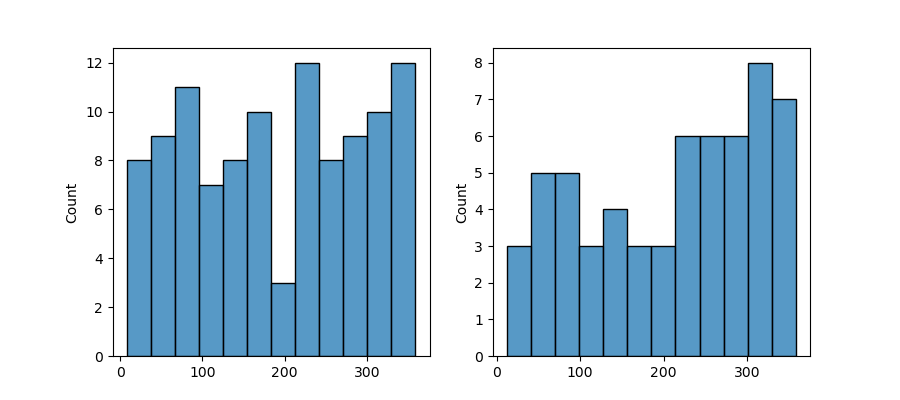

In [22]:
# First get frame number of each usv.
usv_start_frames = (usv_epochs.starts * tparams.fs).astype(int)
usv_start_frames

# Get theta power for each call start
# high_theta_usv_start_times = theta_epochs.contains(usv_epochs.starts)  # This might be too conservative
usv_start_theta_power = theta_power[usv_start_frames]

# Only include calls with above average theta power
theta_thresh = 0  # units = std (theta power is z-scored)
high_usv_power_bool = usv_start_theta_power > theta_thresh
high_theta_usv_start_frames = usv_start_frames[high_usv_power_bool]

# Next, calculate theta phase angle at each usv start
phase_start = tparams.angle[usv_start_frames]
high_theta_phase_start = tparams.angle[high_theta_usv_start_frames]

# Plot histogram of usv start angles
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.histplot(phase_start, binwidth=30, ax=ax[0])
sns.histplot(high_theta_phase_start, binwidth=30, ax=ax[1])

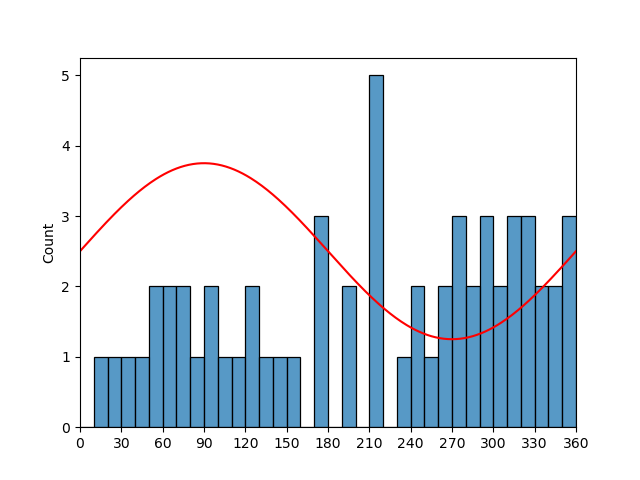

In [23]:
binsize = 10  # in degrees

# Set up plot
a, ax = plt.subplots()

# Fake usv theta phase data and plot a histogram of it
sns.histplot(high_theta_phase_start, bins=np.arange(0, 361, binsize))
counts, _ = np.histogram(high_theta_phase_start, bins=np.arange(0, 361, binsize))

# Plot sine curve over histogram in red ('r-')
phases = np.arange(0, 361, 1)
counts_max = np.max(counts)
ax.plot(phases, np.sin(phases*np.pi/180)*counts_max/4 + counts_max/2, 'r-')

# Adjust x-axis limits and set ticks to appropriate spacing
tick_spacing = 30
ax.set_xlim((0, 360))
ax.set_xticks(np.arange(0, 361, tick_spacing))


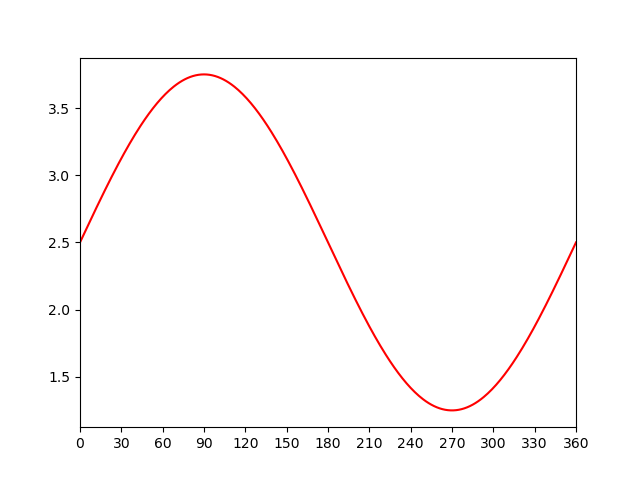

In [24]:
binsize = 10  # in degrees

# Set up plot
a, ax = plt.subplots()


# Plot sine curve over histogram in red ('r-')
phases = np.arange(0, 361, 1)
counts_max = np.max(counts)
ax.plot(phases, np.sin(phases*np.pi/180)*counts_max/4 + counts_max/2, 'r-')

# Adjust x-axis limits and set ticks to appropriate spacing
tick_spacing = 30
ax.set_xlim((0, 360))
ax.set_xticks(np.arange(0, 361, tick_spacing))


In [25]:
a.savefig('/home/bowenw/Documents/thesisplots/sin curve example.png')

Text(0.5, 1.0, 'Calls during high theta periods')

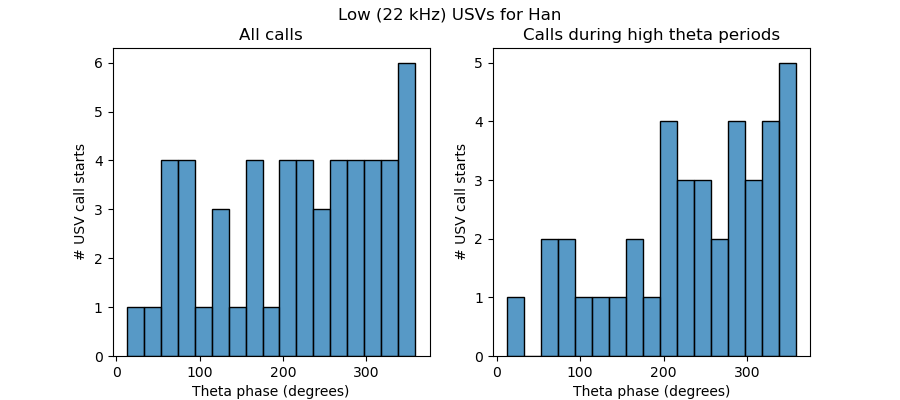

In [26]:
#Histogram for low USVs
# First get frame number of each usv.
import matplotlib.pyplot as plt
lowusv_epochs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min<=23]
lowusv_epochs
lowusv_start_frames = (lowusv_epochs.start * tparams.fs).astype(int)
lowusv_start_frames

# Get theta power for each call start
# high_theta_usv_start_times = theta_epochs.contains(usv_epochs.starts)  # This might be too conservative
lowusv_start_theta_power = theta_power[lowusv_start_frames]

# Only include calls with above average theta power
theta_thresh = 0  # units = std (theta power is z-scored)
lowusv_high_usv_power_bool = lowusv_start_theta_power > theta_thresh
lowusv_high_theta_usv_start_frames = lowusv_start_frames[lowusv_high_usv_power_bool]

# Next, calculate theta phase angle at each usv start
lowusv_phase_start = tparams.angle[lowusv_start_frames]
lowusv_high_theta_phase_start = tparams.angle[lowusv_high_theta_usv_start_frames]

# Plot histogram of usv start angles
fig, ax = plt.subplots(1, 2, figsize=(9, 4))  # Assign the figure object to `fig`
sns.histplot(lowusv_phase_start, binwidth=20, ax=ax[0])
sns.histplot(lowusv_high_theta_phase_start, binwidth=20, ax=ax[1])

# Label axes
fig.suptitle(f"Low (22 kHz) USVs for {animal}")
for a in ax:
    a.set_xlabel('Theta phase (degrees)')
    a.set_ylabel('# USV call starts')

ax[0].set_title("All calls")
ax[1].set_title("Calls during high theta periods")

In [27]:
lowusv_epochs.t_start_eeg

42      886.057849
46      889.257760
47      891.056357
48      892.678487
49      895.247201
50      897.055591
51      902.581054
52      907.374273
53      908.674107
54      911.623731
55      912.881390
56      918.512029
57      919.762692
58      926.321870
59      927.590340
60      932.985826
61      934.307641
62      947.058276
71     1389.121883
72     1390.498312
73     1391.134265
74     1392.079004
75     1392.518229
76     1393.156415
77     1395.765462
78     1396.580645
79     1397.082830
80     1397.751072
81     1398.525037
82     1607.908197
83     1609.166301
84     1609.429604
85     1609.674538
86     1609.942517
87     1610.221866
88     1610.835948
89     1611.230465
90     1611.879100
91     1612.183955
92     1612.812426
93     1613.496830
94     1614.155632
95     1614.895121
96     1621.027330
97     1621.813010
98     1622.344769
99     1622.948489
100    1623.608147
101    1624.159181
102    1624.587944
103    1625.300156
104    1625.886424
105    1626.

Text(0.5, 1.0, 'Calls during high theta periods')

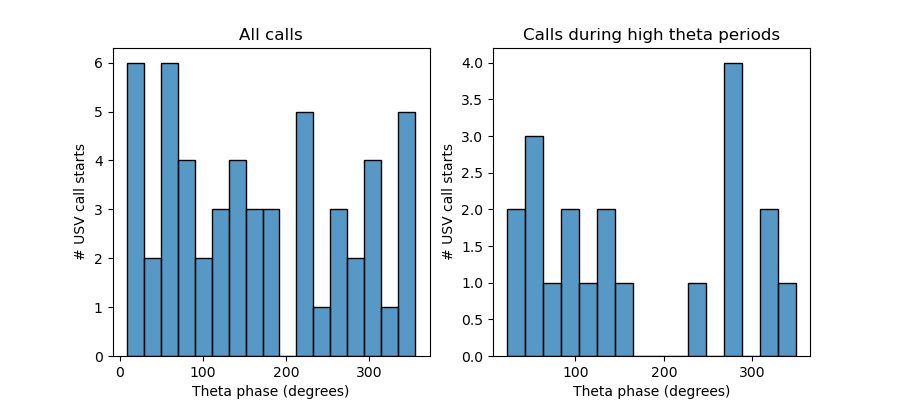

In [28]:
#Histogram for high USVs
# First get frame number of each usv.
highusv_epochs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min>23]
highusv_epochs
highusv_start_frames = (highusv_epochs.start * tparams.fs).astype(int)
highusv_start_frames

# Get theta power for each call start
# high_theta_usv_start_times = theta_epochs.contains(usv_epochs.starts)  # This might be too conservative
highusv_start_theta_power = theta_power[highusv_start_frames]

# Only include calls with above average theta power
theta_thresh = 0  # units = std (theta power is z-scored)
highusv_high_usv_power_bool = highusv_start_theta_power > theta_thresh
highusv_high_theta_usv_start_frames = highusv_start_frames[highusv_high_usv_power_bool]

# Next, calculate theta phase angle at each usv start
highusv_phase_start = tparams.angle[highusv_start_frames]
highusv_high_theta_phase_start = tparams.angle[highusv_high_theta_usv_start_frames]

# Plot histogram of usv start angles
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.histplot(highusv_phase_start, binwidth=20, ax=ax[0])
sns.histplot(highusv_high_theta_phase_start, binwidth=20, ax=ax[1])

# Label axes
fig.suptitle(f"High (50 kHz) USVs for {animal}")
for a in ax:
    a.set_xlabel('Theta phase (degrees)')
    a.set_ylabel('# USV call starts')

ax[0].set_title("All calls")
ax[1].set_title("Calls during high theta periods")

In [29]:
highusv_high_theta_phase_start

array([241.46341463,  34.17721519,  96.92307692,  60.        ,
       272.96703297, 267.69230769, 324.25531915, 119.3877551 ,
        46.        ,  96.        , 153.10344828, 284.57142857,
       311.67785235, 128.34782609, 270.66666667, 133.78378378,
        22.90909091,  65.45454545, 349.09090909,  62.54237288])

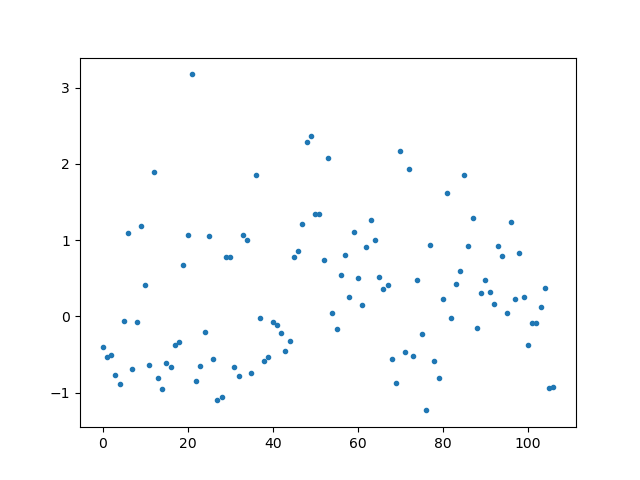

In [30]:
_, ax = plt.subplots()
ax.plot(usv_start_theta_power, '.')

In [31]:
usv_start_frames[high_usv_power_bool]

array([ 560356,  562189,  562585,  564914,  569540,  571575,  572247,
        575951,  581045,  581070,  583942,  584016,  586101,  594301,
        594353,  596601,  598629,  601840,  604101,  611009,  617001,
        618626,  622314,  630925,  632489,  640689,  642274,  649020,
        650672,  666612,  898355,  898635,  904345,  904371,  904627,
        923604, 1220983, 1222959, 1227568, 1230050, 1231018, 1541831,
       1542160, 1542467, 1542802, 1543151, 1544412, 1545223, 1545604,
       1546390, 1547245, 1548069, 1548993, 1556660, 1557642, 1558307,
       1559062, 1562002, 1562734])

In [32]:
high_usv_power_bool

array([False, False, False, False, False, False,  True, False, False,
        True,  True, False,  True, False, False, False, False, False,
       False,  True,  True,  True, False, False, False,  True, False,
       False, False,  True,  True, False, False,  True,  True, False,
        True, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False,  True, False,
        True, False,  True, False, False,  True, False, False,  True,
        True, False,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False,  True,  True, False, False])

/tmp/ipykernel_3296526/3395203564.py:18: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((start_time, 0.6), duration, 0.4, color='blue', edgecolor='none', alpha=0.5)
/tmp/ipykernel_3296526/3395203564.py:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((start_time, 0.1), duration, 0.4, color='green', edgecolor='none', alpha=0.5)


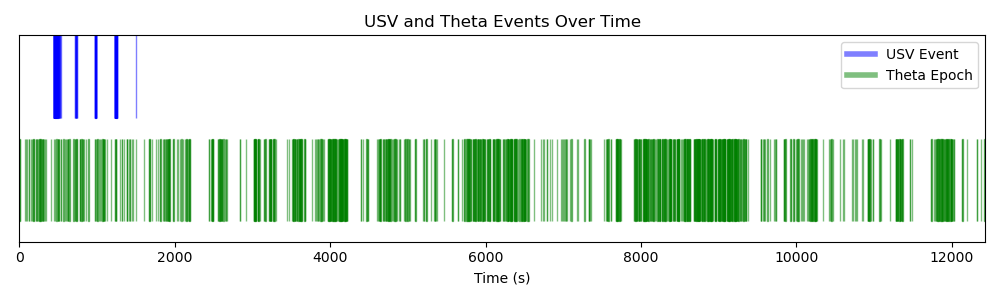

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

usv_start_times = usv_epochs.starts 
usv_stop_times = usv_epochs.stops  
usv_durations = usv_epochs.stops-usv_epochs.starts  

theta_start_times = theta_epochs.starts  
theta_stop_times = theta_epochs.stops  
theta_durations = theta_stop_times - theta_start_times 

fig, ax = plt.subplots(figsize=(10, 3))  

# Plot USV events
for start_time, duration in zip(usv_start_times, usv_durations):
    rect = Rectangle((start_time, 0.6), duration, 0.4, color='blue', edgecolor='none', alpha=0.5)
    ax.add_patch(rect)

# Plot Theta epochs
for start_time, duration in zip(theta_start_times, theta_durations):
    rect = Rectangle((start_time, 0.1), duration, 0.4, color='green', edgecolor='none', alpha=0.5)
    ax.add_patch(rect)


from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='blue', lw=4, alpha=0.5), Line2D([0], [0], color='green', lw=4, alpha=0.5)]
ax.legend(custom_lines, ['USV Event', 'Theta Epoch'])

ax.set_xlim(0, max(np.max(usv_stop_times), np.max(theta_stop_times)) + 1)
ax.set_ylim(0, 1)
ax.set_xlabel('Time (s)')
ax.set_yticks([])
plt.title('USV and Theta Events Over Time')
plt.tight_layout()
plt.show()

/tmp/ipykernel_3296526/1734047521.py:22: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((start_time, 0.4), duration, 0.3, color='darkblue', edgecolor='none', alpha=0.7)
/tmp/ipykernel_3296526/1734047521.py:31: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((start_time, 0.4), duration, 0.3, color='lightblue', edgecolor='none', alpha=0.5)
/tmp/ipykernel_3296526/1734047521.py:37: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((start_time, 0.1), duration, 0.3, color='green', edgecolor='none', alpha=0.5)


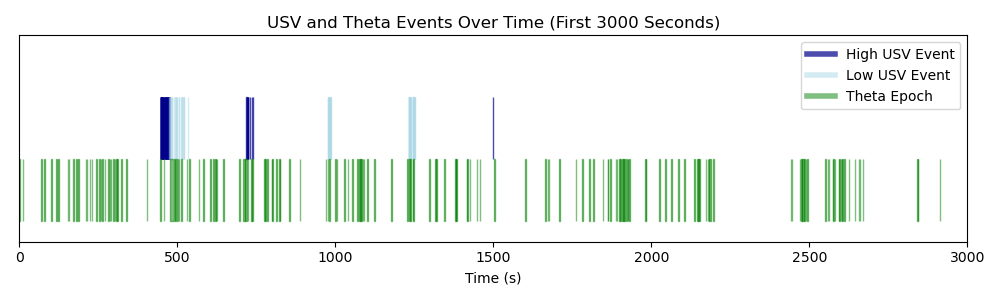

In [34]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Assuming theta_epochs are defined elsewhere
theta_start_times = theta_epochs.starts
theta_stop_times = theta_epochs.stops
theta_durations = theta_stop_times - theta_start_times

usv_start_times = usv_epochs.starts
usv_stop_times = usv_epochs.stops
usv_durations = usv_epochs.stops - usv_epochs.starts

fig, ax = plt.subplots(figsize=(10, 3))

# Plot high USV events in another color (now on top)
for _, row in highusv_epochs.iterrows():
    start_time = row['start']
    stop_time = row['stop']
    duration = stop_time - start_time
    if start_time <= 3000:  # Limit to the first 3000 seconds
        rect = Rectangle((start_time, 0.4), duration, 0.3, color='darkblue', edgecolor='none', alpha=0.7)
        ax.add_patch(rect)

# Plot low USV events in one color (now second from top)
for _, row in lowusv_epochs.iterrows():
    start_time = row['start']
    stop_time = row['stop']
    duration = stop_time - start_time
    if start_time <= 3000:  # Limit to the first 3000 seconds
        rect = Rectangle((start_time, 0.4), duration, 0.3, color='lightblue', edgecolor='none', alpha=0.5)
        ax.add_patch(rect)

# Plot Theta epochs (now third from top)
for start_time, duration in zip(theta_start_times, theta_durations):
    if start_time <= 3000:  # Limit to the first 3000 seconds
        rect = Rectangle((start_time, 0.1), duration, 0.3, color='green', edgecolor='none', alpha=0.5)
        ax.add_patch(rect)

# Customize the legend
custom_lines = [
    Line2D([0], [0], color='darkblue', lw=4, alpha=0.7),
    Line2D([0], [0], color='lightblue', lw=4, alpha=0.5),
    Line2D([0], [0], color='green', lw=4, alpha=0.5),
]
ax.legend(custom_lines, ['High USV Event', 'Low USV Event', 'Theta Epoch'])

# Adjust limits and labels
ax.set_xlim(0, 3000)  # Limit x-axis to the first 3000 seconds
ax.set_ylim(0, 1)  # Adjusted to accommodate all rows without overlapping
ax.set_xlabel('Time (s)')
ax.set_yticks([])
plt.title('USV and Theta Events Over Time (First 3000 Seconds)')
plt.tight_layout()
plt.show()

In [35]:
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times

theta_off_usv_on_times = [theta_epochs.stops, usv_epochs.start]
theta_off_usv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_usv_on_times)])
theta_off_usv_on_times = np.hstack(theta_off_usv_on_times)
sort_ids = np.argsort(theta_off_usv_on_times)

theta_off_usv_on_times = theta_off_usv_on_times[sort_ids]
theta_off_usv_on_ids = theta_off_usv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_usv_on_times, theta_off_usv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)

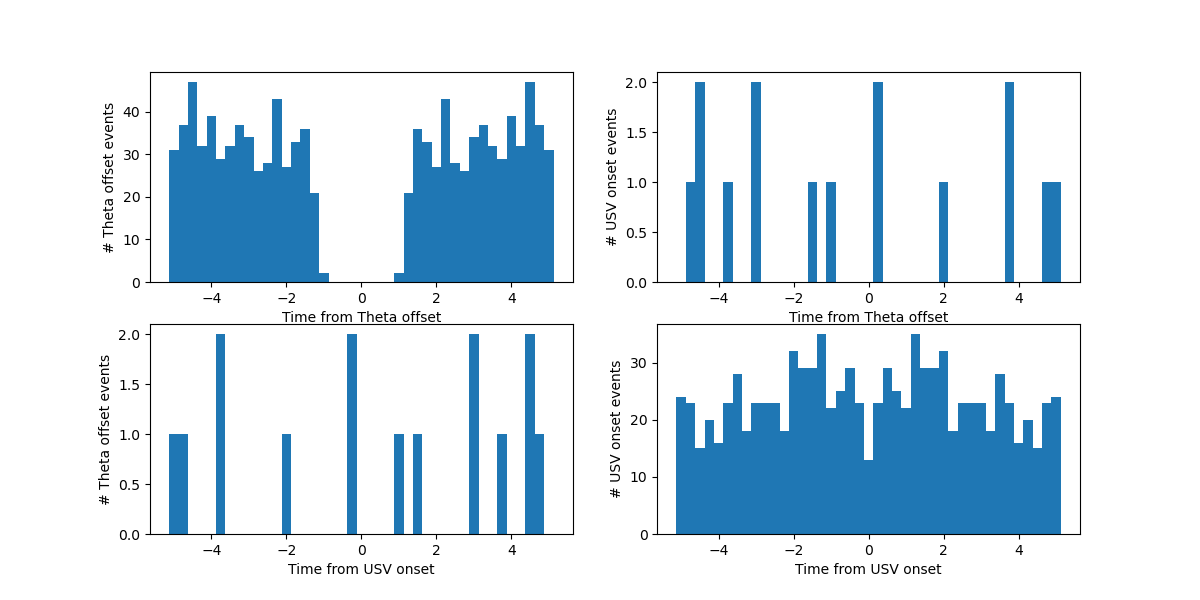

In [36]:
# Sample plotting code
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
_, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['Theta offset', 'USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")


In [37]:
#low usv
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_lowusv_on_times = [theta_epochs.stops, low_usv_epochs.start]
theta_off_lowusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_lowusv_on_times)])
theta_off_lowusv_on_times = np.hstack(theta_off_lowusv_on_times)
sort_ids = np.argsort(theta_off_lowusv_on_times)

theta_off_lowusv_on_times = theta_off_lowusv_on_times[sort_ids]
theta_off_lowusv_on_ids = theta_off_lowusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_lowusv_on_times, theta_off_lowusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)

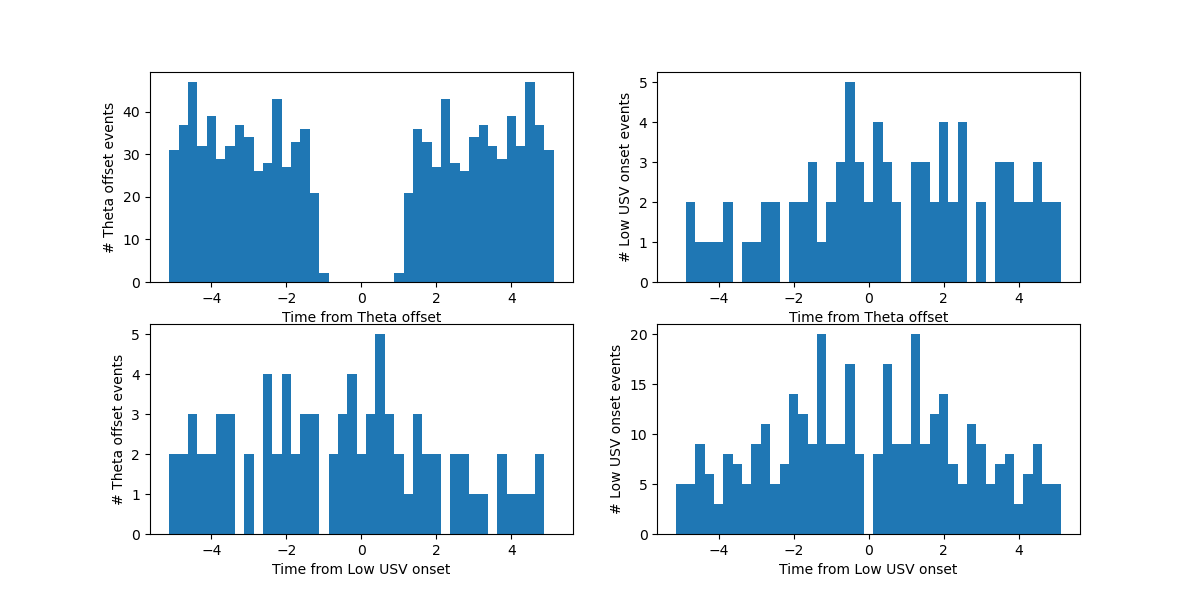

In [38]:
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
_, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['Theta offset', 'Low USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")

In [39]:
#high usv
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_highusv_on_times = [theta_epochs.stops, high_usv_epochs.start]
theta_off_highusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_highusv_on_times)])
theta_off_highusv_on_times = np.hstack(theta_off_highusv_on_times)
sort_ids = np.argsort(theta_off_highusv_on_times)

theta_off_highusv_on_times = theta_off_highusv_on_times[sort_ids]
theta_off_highusv_on_ids = theta_off_highusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_highusv_on_times, theta_off_highusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)

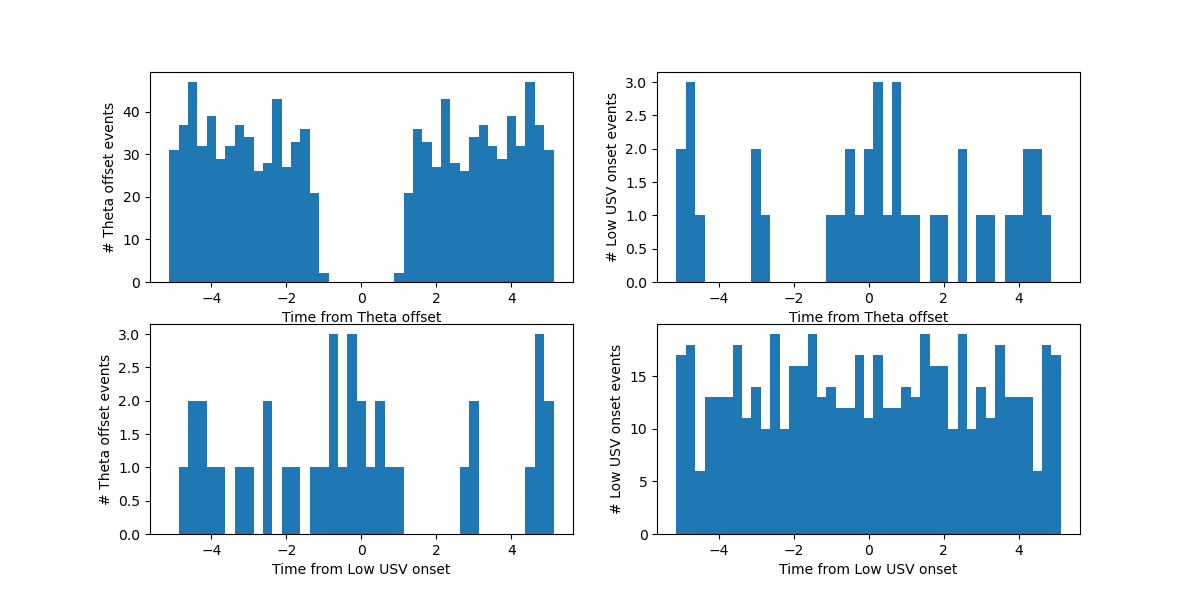

In [40]:
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
_, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['Theta offset', 'Low USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")

In [41]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 8
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
exclude_theta_epochs = False  # make this true if you end up with a lot of false positive ripples as gamma events during theta

if not exclude_theta_epochs:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff, ignore_epochs=art_epochs)
else:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff,
                                         ignore_epochs=art_epochs.__add__(theta_epochs))
sess.recinfo.write_epochs(ripple_epochs, ext='swr')
ripple_epochs_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
ripple_epochs.save(ripple_epochs_file)

Selected channels for ripples: [8]
8013 epochs remaining with durations within (0.05,0.45)
/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training.ripple_epochs.npy saved


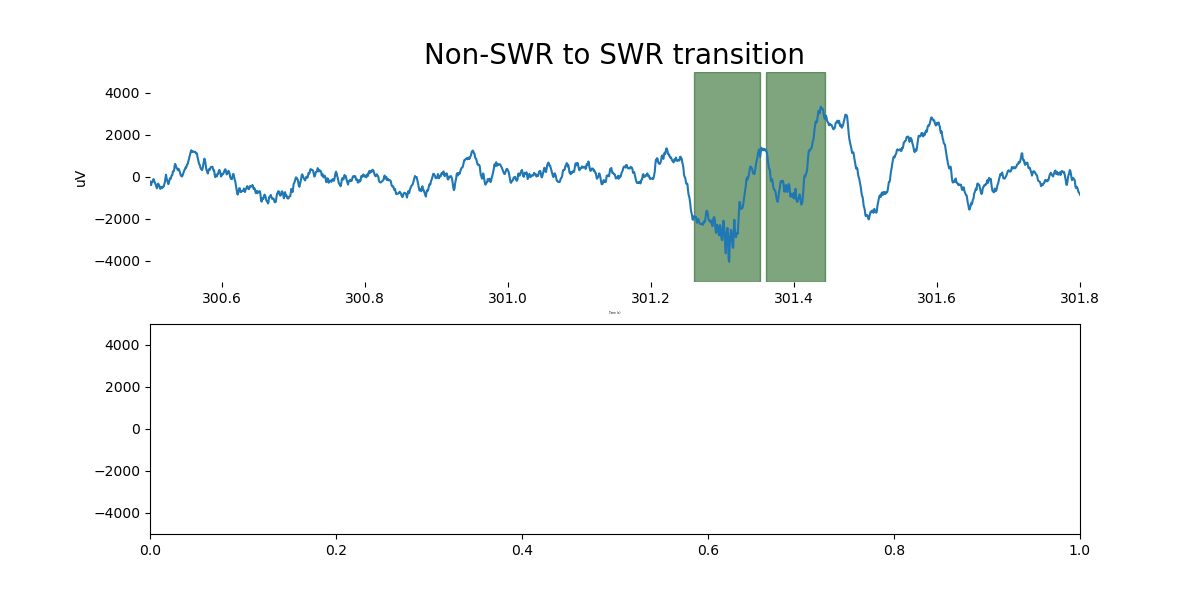

In [42]:
%matplotlib widget
fig, ax = plt.subplots(2, 1, sharex=False, sharey=True, figsize=(12, 6))
chan_plot = ripple_channel
plot_signal_w_epochs(signal, chan_plot, ripple_epochs, ax=ax[0])
# plot_signal_w_epochs(signal, chan_plot, art_epochs, ax=ax[1])

# Good example 2178 to 1282 seconds

# great theta starts at 475 seconds
# How to pretty up your plots

# 0) automatically zoom to right spot/limits
ax[0].set_xlim((300.5, 301.8))
ax[0].set_ylim((-5000, 5000))
# 1) remove top and right axes
sns.despine(ax=ax[0])
# 1a) (optional remove ALL axes)
sns.despine(ax=ax[0], left=True, bottom=True)
# 1b) Turn off ticks too
# ax[0].set_xticks([], minor=False)
# ax[0].set_yticks([], minor=False)
# 2) label axes
ax[0].set_xlabel('Time (s)', fontsize=2)
ax[0].set_ylabel('uV')
ax[0].set_title('Non-SWR to SWR transition', fontsize=20)
#3) Turn on xticks on top
ax[0].tick_params(axis='both', which='both')


In [43]:
fig.savefig('/home/bowenw/Documents/thesisplots/SWR transition plot.png')

In [44]:
# Convert ripple epochs to binned ripple rate
t, rip_bool = ripple_epochs.to_point_process()
from neuropy.core.neurons import BinnedSpiketrain, Neurons
rips = Neurons(t[None, rip_bool], t_stop=50*60)

In [45]:
bin_size_sec = 1
binned_rips = rips.get_binned_spiketrains(bin_size=bin_size_sec)

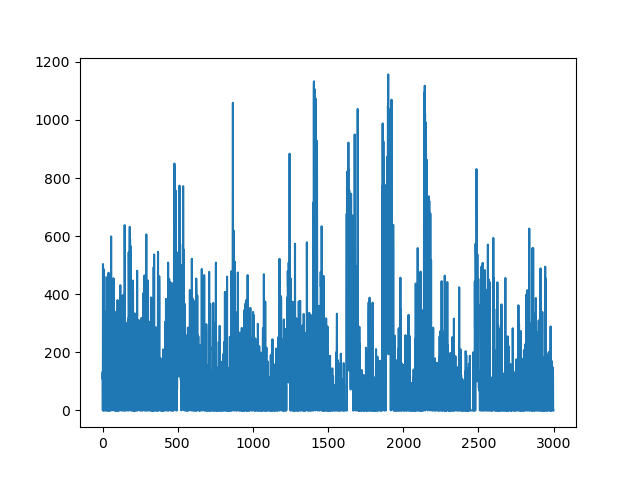

In [46]:
_, ax = plt.subplots()
ax.plot(binned_rips.time, binned_rips.firing_rate[0])

/tmp/ipykernel_3296526/1711853227.py:22: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((start_time, 0.4), duration, 0.3, color='darkblue', edgecolor='none', alpha=0.7)
/tmp/ipykernel_3296526/1711853227.py:31: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((start_time, 0.4), duration, 0.3, color='lightblue', edgecolor='none', alpha=0.5)
/tmp/ipykernel_3296526/1711853227.py:37: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((start_time, 0.1), duration, 0.3, color='green', edgecolor='none', alpha=0.5)


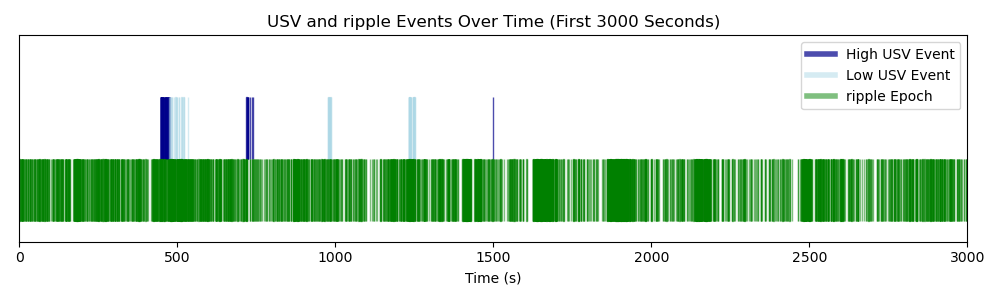

In [47]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Assuming ripple_epochs are defined elsewhere
ripple_start_times = ripple_epochs.starts
ripple_stop_times = ripple_epochs.stops
ripple_durations = ripple_stop_times - ripple_start_times

usv_start_times = usv_epochs.starts
usv_stop_times = usv_epochs.stops
usv_durations = usv_epochs.stops - usv_epochs.starts

fig, ax = plt.subplots(figsize=(10, 3))

# Plot high USV events in another color (now on top)
for _, row in highusv_epochs.iterrows():
    start_time = row['start']
    stop_time = row['stop']
    duration = stop_time - start_time
    if start_time <= 3000:  # Limit to the first 3000 seconds
        rect = Rectangle((start_time, 0.4), duration, 0.3, color='darkblue', edgecolor='none', alpha=0.7)
        ax.add_patch(rect)

# Plot low USV events in one color (now second from top)
for _, row in lowusv_epochs.iterrows():
    start_time = row['start']
    stop_time = row['stop']
    duration = stop_time - start_time
    if start_time <= 3000:  # Limit to the first 3000 seconds
        rect = Rectangle((start_time, 0.4), duration, 0.3, color='lightblue', edgecolor='none', alpha=0.5)
        ax.add_patch(rect)

# Plot ripple epochs (now third from top)
for start_time, duration in zip(ripple_start_times, ripple_durations):
    if start_time <= 3000:  # Limit to the first 3000 seconds
        rect = Rectangle((start_time, 0.1), duration, 0.3, color='green', edgecolor='none', alpha=0.5)
        ax.add_patch(rect)

# Customize the legend
custom_lines = [
    Line2D([0], [0], color='darkblue', lw=4, alpha=0.7),
    Line2D([0], [0], color='lightblue', lw=4, alpha=0.5),
    Line2D([0], [0], color='green', lw=4, alpha=0.5),
]
ax.legend(custom_lines, ['High USV Event', 'Low USV Event', 'ripple Epoch'])

# Adjust limits and labels
ax.set_xlim(0, 3000)  # Limit x-axis to the first 3000 seconds
ax.set_ylim(0, 1)  # Adjusted to accommodate all rows without overlapping
ax.set_xlabel('Time (s)')
ax.set_yticks([])
plt.title('USV and ripple Events Over Time (First 3000 Seconds)')
plt.tight_layout()
plt.show()

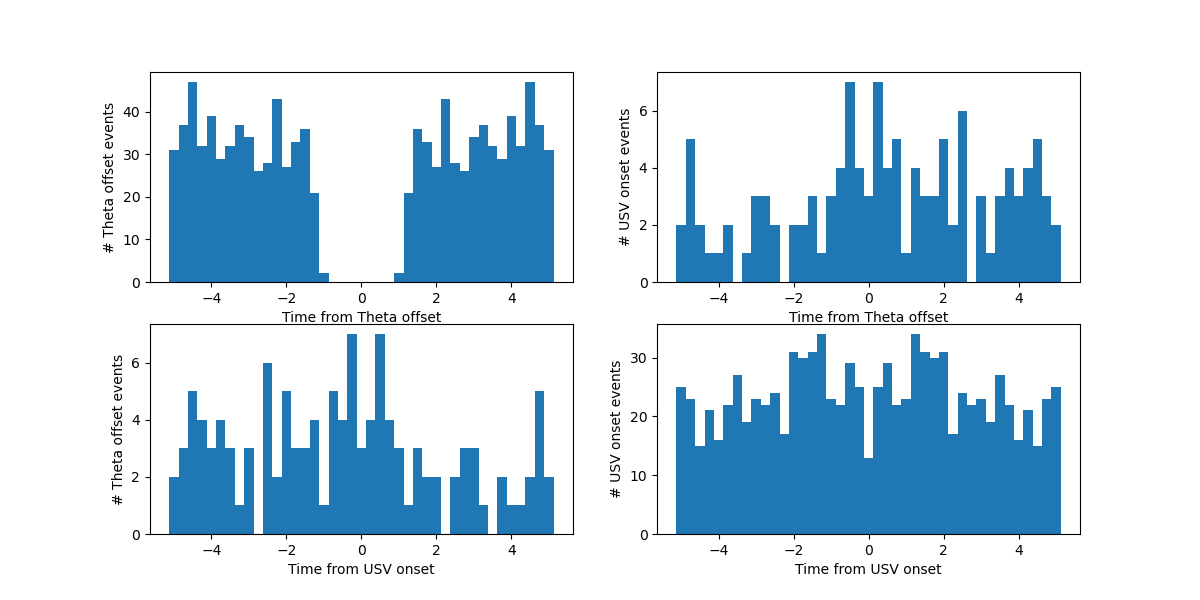

In [48]:
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_usv_on_times = [theta_epochs.stops, usv_epochs.starts]
theta_off_usv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_usv_on_times)])
theta_off_usv_on_times = np.hstack(theta_off_usv_on_times)
sort_ids = np.argsort(theta_off_usv_on_times)

theta_off_usv_on_times = theta_off_usv_on_times[sort_ids]
theta_off_usv_on_ids = theta_off_usv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_usv_on_times, theta_off_usv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
_, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['Theta offset', 'USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
fig.savefig('/home/bowenw/Documents/thesisplots/Han usv-theta ccg all.png')

/tmp/ipykernel_3296526/885783852.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots(2, 2, figsize=(12, 6))


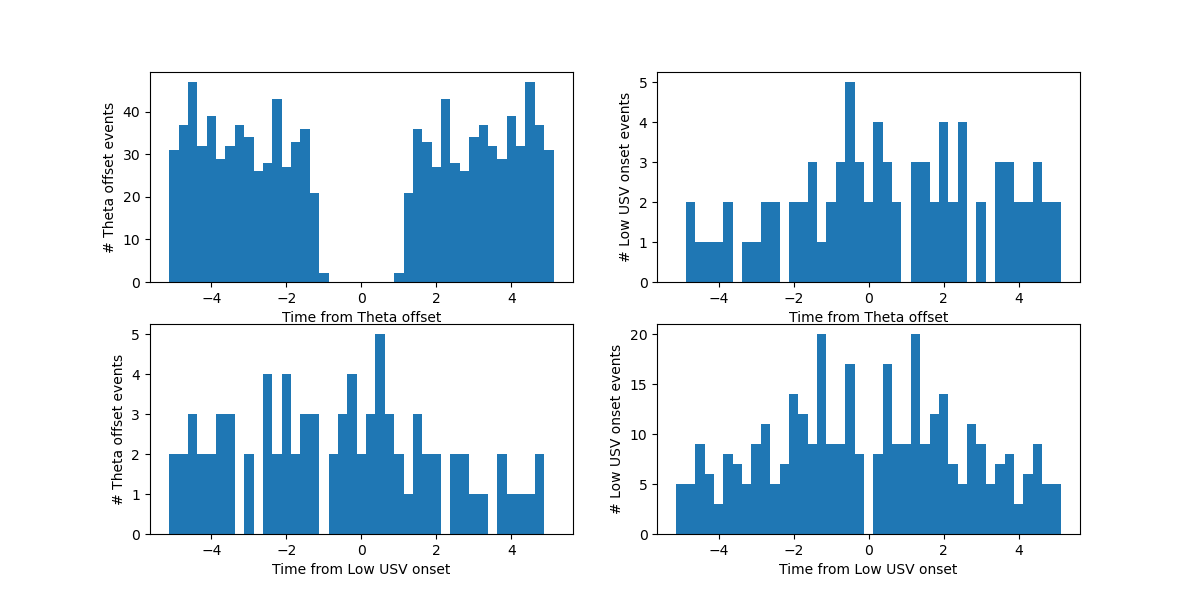

In [49]:
#low usv
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_lowusv_on_times = [theta_epochs.stops, low_usv_epochs.start]
theta_off_lowusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_lowusv_on_times)])
theta_off_lowusv_on_times = np.hstack(theta_off_lowusv_on_times)
sort_ids = np.argsort(theta_off_lowusv_on_times)

theta_off_lowusv_on_times = theta_off_lowusv_on_times[sort_ids]
theta_off_lowusv_on_ids = theta_off_lowusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_lowusv_on_times, theta_off_lowusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
_, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['Theta offset', 'Low USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
fig.savefig('/home/bowenw/Documents/thesisplots/Han usv-theta ccg lowusv.png')

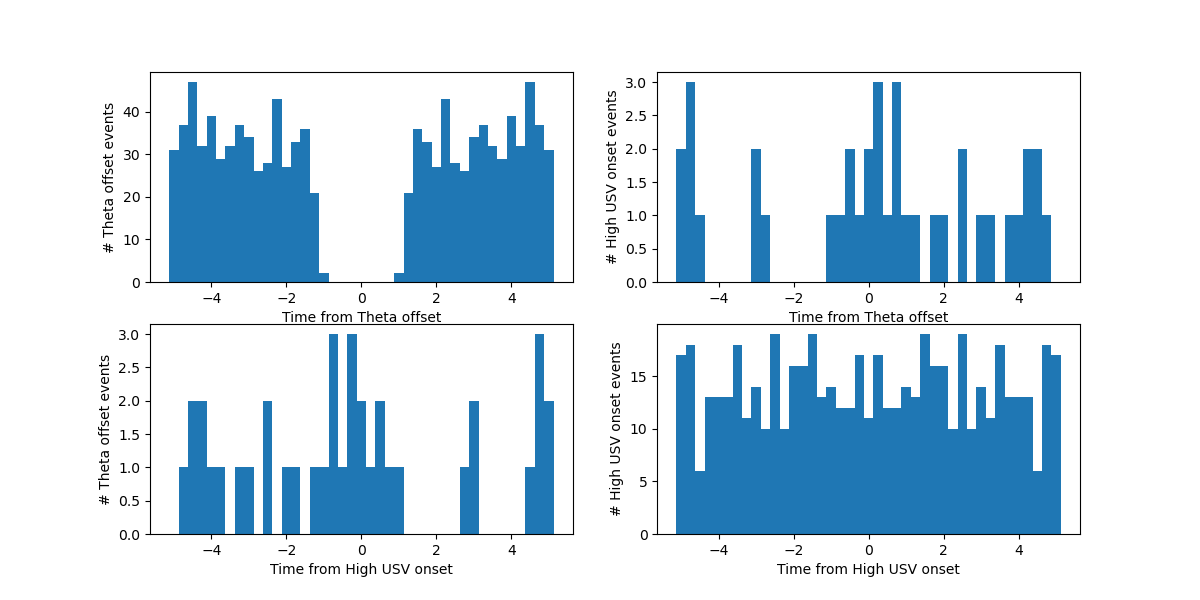

In [50]:
#high usv
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_highusv_on_times = [theta_epochs.stops, high_usv_epochs.start]
theta_off_highusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_highusv_on_times)])
theta_off_highusv_on_times = np.hstack(theta_off_highusv_on_times)
sort_ids = np.argsort(theta_off_highusv_on_times)

theta_off_highusv_on_times = theta_off_highusv_on_times[sort_ids]
theta_off_highusv_on_ids = theta_off_highusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_highusv_on_times, theta_off_highusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
_, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['Theta offset', 'High USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
fig.savefig('/home/bowenw/Documents/thesisplots/Han usv-theta ccg highusv.png')

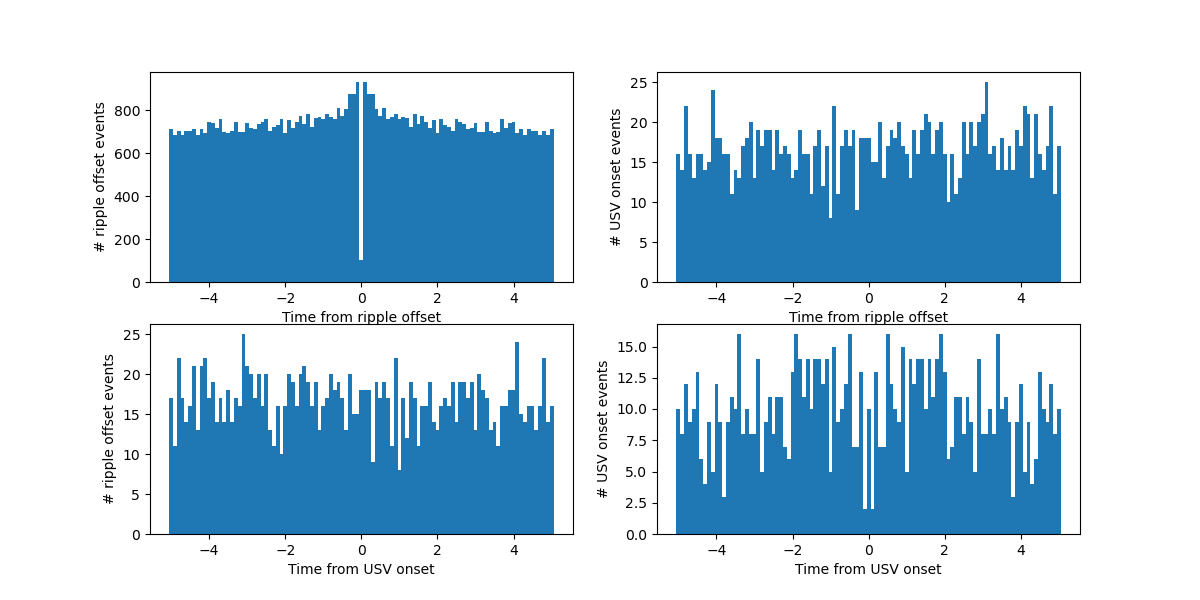

In [51]:
from neuropy.utils.ccg import correlograms

# We observe that right after ripple ends there seem to be a lot of USVs starting - check this by looking at CCG between ripple off and
# USV onset times
ripple_off_usv_on_times = [ripple_epochs.stops, usv_epochs.starts]
ripple_off_usv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(ripple_off_usv_on_times)])
ripple_off_usv_on_times = np.hstack(ripple_off_usv_on_times)
sort_ids = np.argsort(ripple_off_usv_on_times)

ripple_off_usv_on_times = ripple_off_usv_on_times[sort_ids]
ripple_off_usv_on_ids = ripple_off_usv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.1 # seconds
ccg = correlograms(ripple_off_usv_on_times, ripple_off_usv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
_, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['ripple offset', 'USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
fig.savefig('/home/bowenw/Documents/thesisplots/Han usv-ripple ccg all.png')

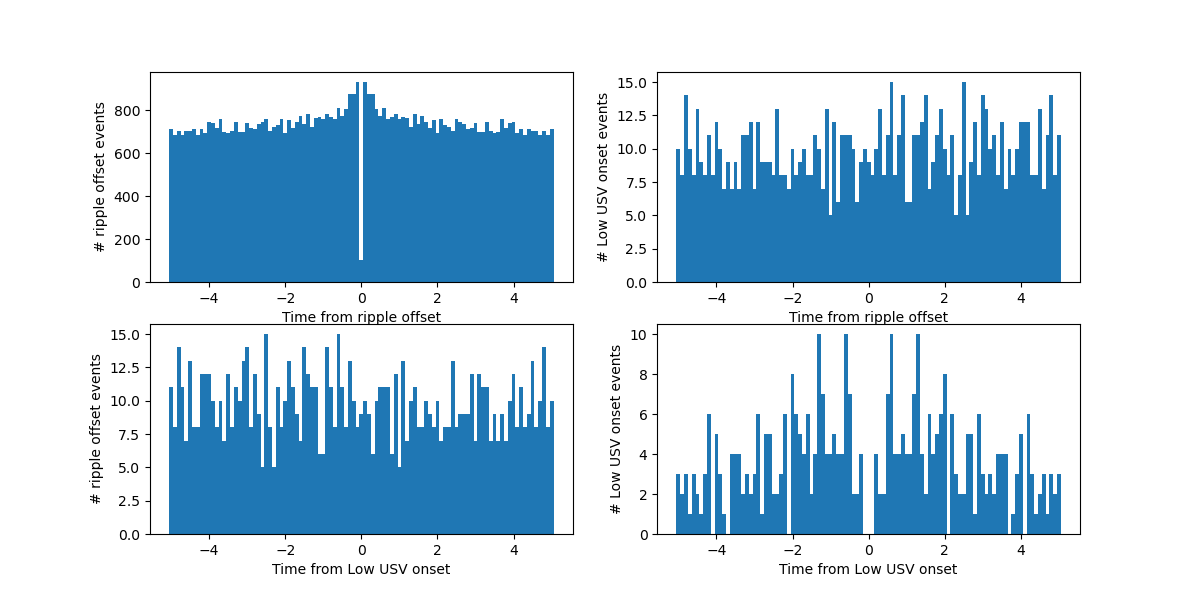

In [52]:
#low usv
from neuropy.utils.ccg import correlograms

# We observe that right after ripple ends there seem to be a lot of USVs starting - check this by looking at CCG between ripple off and
# USV onset times
ripple_off_lowusv_on_times = [ripple_epochs.stops, low_usv_epochs.start]
ripple_off_lowusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(ripple_off_lowusv_on_times)])
ripple_off_lowusv_on_times = np.hstack(ripple_off_lowusv_on_times)
sort_ids = np.argsort(ripple_off_lowusv_on_times)

ripple_off_lowusv_on_times = ripple_off_lowusv_on_times[sort_ids]
ripple_off_lowusv_on_ids = ripple_off_lowusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.1 # seconds
ccg = correlograms(ripple_off_lowusv_on_times, ripple_off_lowusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
_, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['ripple offset', 'Low USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
fig.savefig('/home/bowenw/Documents/thesisplots/Han usv-ripple ccg lowusv.png')

## All theta USV ccg

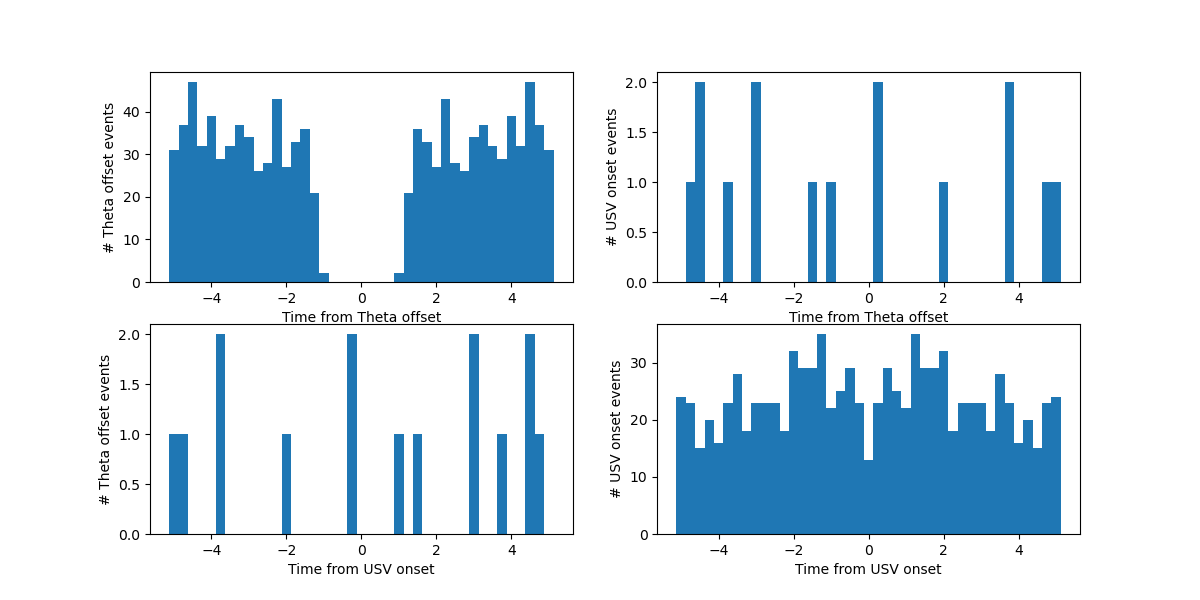

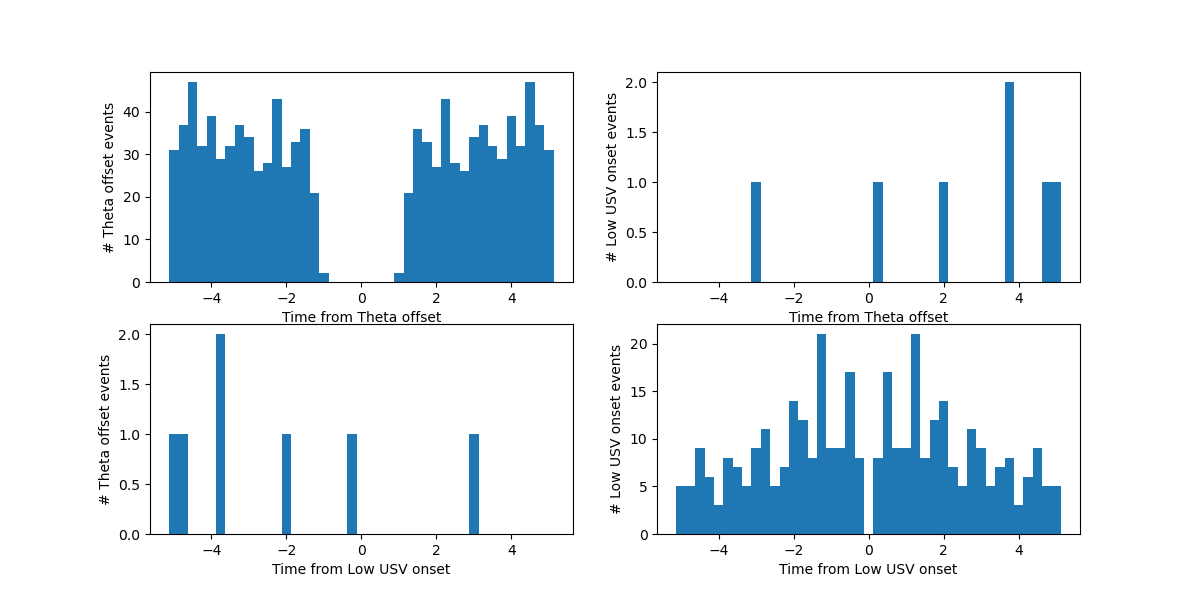

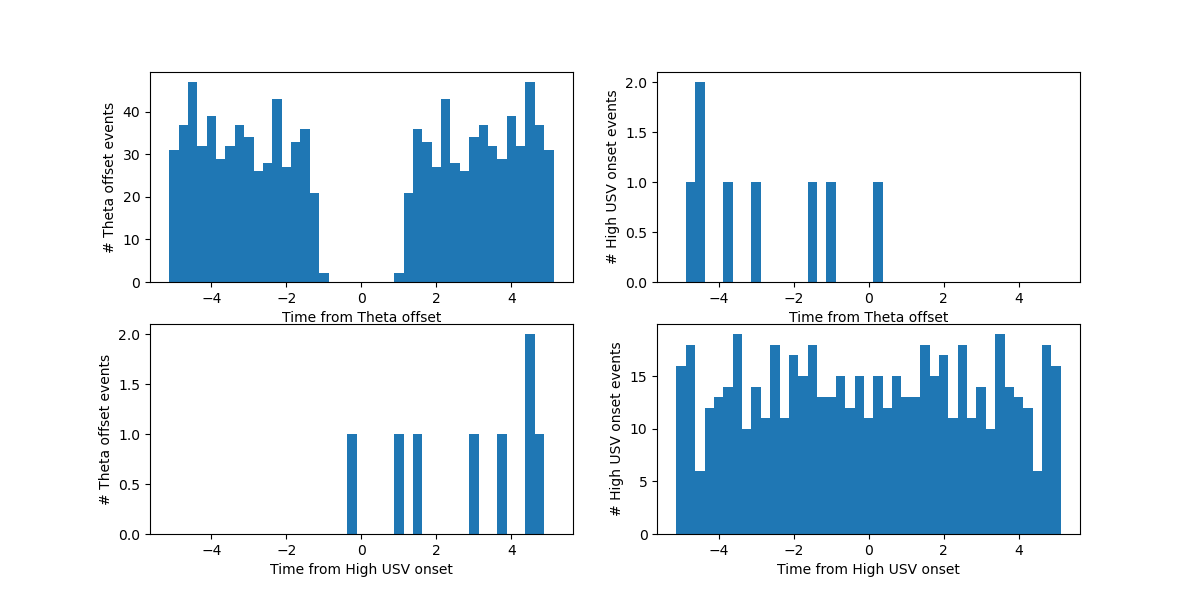

In [53]:
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_usv_on_times = [theta_epochs.stops, usv_epochs._epochs.t_start_eeg]
theta_off_usv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_usv_on_times)])
theta_off_usv_on_times = np.hstack(theta_off_usv_on_times)
sort_ids = np.argsort(theta_off_usv_on_times)

theta_off_usv_on_times = theta_off_usv_on_times[sort_ids]
theta_off_usv_on_ids = theta_off_usv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_usv_on_times, theta_off_usv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr1_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['Theta offset', 'USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")

corr1_fig.savefig('/home/bowenw/Documents/thesisplots/Han usv-theta ccg all.png')

#low usv
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_lowusv_on_times = [theta_epochs.stops, low_usv_epochs.t_start_eeg]
theta_off_lowusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_lowusv_on_times)])
theta_off_lowusv_on_times = np.hstack(theta_off_lowusv_on_times)
sort_ids = np.argsort(theta_off_lowusv_on_times)

theta_off_lowusv_on_times = theta_off_lowusv_on_times[sort_ids]
theta_off_lowusv_on_ids = theta_off_lowusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_lowusv_on_times, theta_off_lowusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr2_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['Theta offset', 'Low USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")

corr2_fig.savefig('/home/bowenw/Documents/thesisplots/Han usv-theta ccg lowusv.png')

#high usv
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_highusv_on_times = [theta_epochs.stops, highusv_epochs.t_start_eeg]
theta_off_highusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_highusv_on_times)])
theta_off_highusv_on_times = np.hstack(theta_off_highusv_on_times)
sort_ids = np.argsort(theta_off_highusv_on_times)

theta_off_highusv_on_times = theta_off_highusv_on_times[sort_ids]
theta_off_highusv_on_ids = theta_off_highusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_highusv_on_times, theta_off_highusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr3_fig, ax = plt.subplots(2, 2, figsize=(12, 6))


var_names = ['Theta offset', 'High USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
corr3_fig.savefig('/home/bowenw/Documents/thesisplots/Han usv-theta ccg highusv.png')

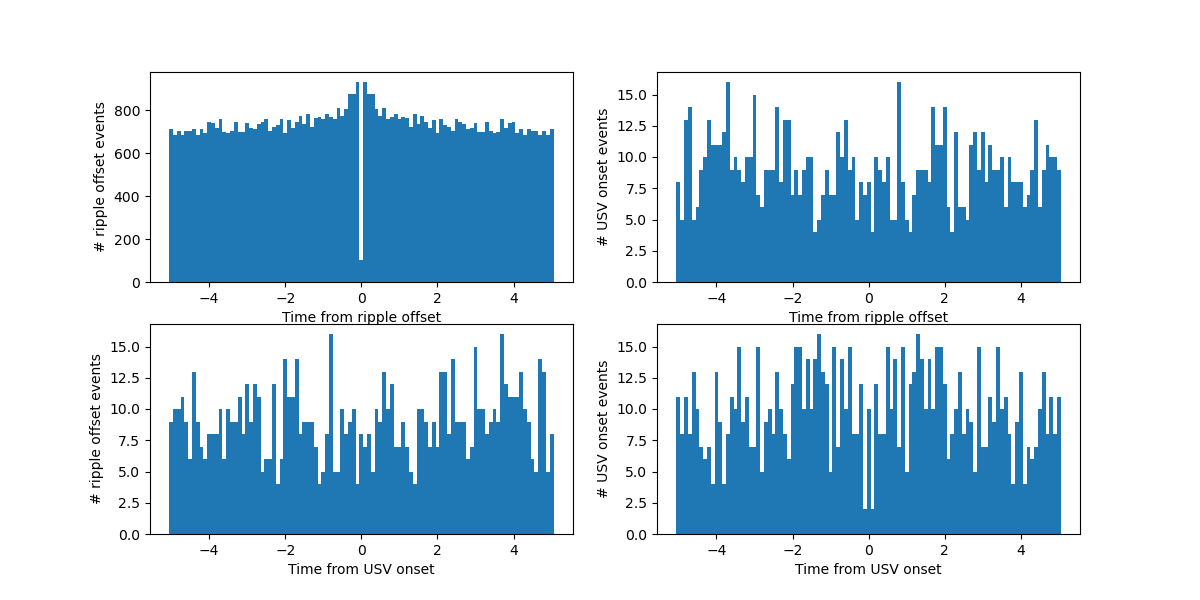

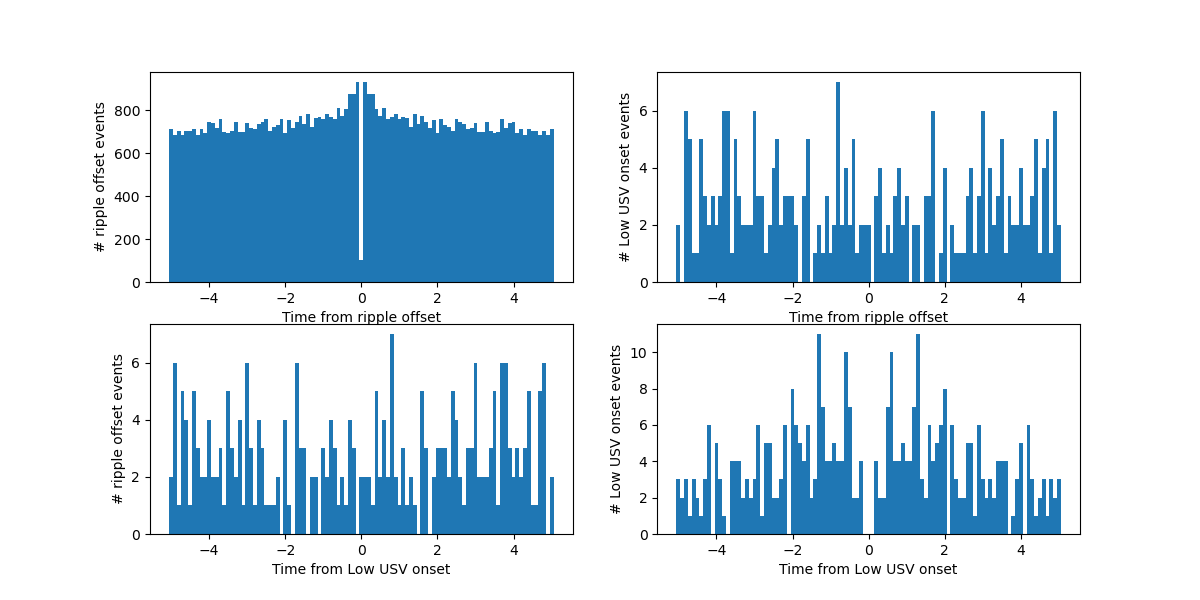

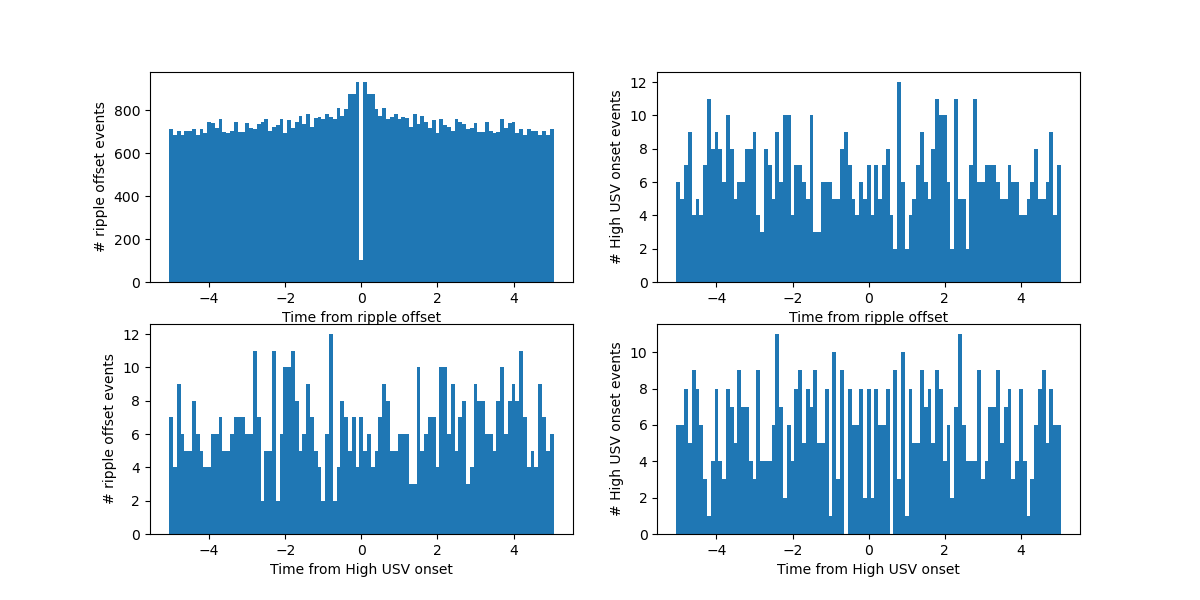

In [54]:
from neuropy.utils.ccg import correlograms

# We observe that right after ripple ends there seem to be a lot of USVs starting - check this by looking at CCG between ripple off and
# USV onset times
ripple_off_usv_on_times = [ripple_epochs.stops, usv_epochs._epochs.t_start_eeg]
ripple_off_usv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(ripple_off_usv_on_times)])
ripple_off_usv_on_times = np.hstack(ripple_off_usv_on_times)
sort_ids = np.argsort(ripple_off_usv_on_times)

ripple_off_usv_on_times = ripple_off_usv_on_times[sort_ids]
ripple_off_usv_on_ids = ripple_off_usv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.1 # seconds
ccg = correlograms(ripple_off_usv_on_times, ripple_off_usv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr4_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['ripple offset', 'USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
corr4_fig.savefig('/home/bowenw/Documents/thesisplots/Han usv-ripple ccg all.png')

#low usv
from neuropy.utils.ccg import correlograms

# We observe that right after ripple ends there seem to be a lot of USVs starting - check this by looking at CCG between ripple off and
# USV onset times
ripple_off_lowusv_on_times = [ripple_epochs.stops, lowusv_epochs.t_start_eeg]
ripple_off_lowusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(ripple_off_lowusv_on_times)])
ripple_off_lowusv_on_times = np.hstack(ripple_off_lowusv_on_times)
sort_ids = np.argsort(ripple_off_lowusv_on_times)

ripple_off_lowusv_on_times = ripple_off_lowusv_on_times[sort_ids]
ripple_off_lowusv_on_ids = ripple_off_lowusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.1 # seconds
ccg = correlograms(ripple_off_lowusv_on_times, ripple_off_lowusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr5_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['ripple offset', 'Low USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
corr5_fig.savefig('/home/bowenw/Documents/thesisplots/Han usv-ripple ccg lowusv.png')

#high usv
from neuropy.utils.ccg import correlograms

# We observe that right after ripple ends there seem to be a lot of USVs starting - check this by looking at CCG between ripple off and
# USV onset times
ripple_off_highusv_on_times = [ripple_epochs.stops, highusv_epochs.t_start_eeg]
ripple_off_highusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(ripple_off_highusv_on_times)])
ripple_off_highusv_on_times = np.hstack(ripple_off_highusv_on_times)
sort_ids = np.argsort(ripple_off_highusv_on_times)

ripple_off_highusv_on_times = ripple_off_highusv_on_times[sort_ids]
ripple_off_highusv_on_ids = ripple_off_highusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.1 # seconds
ccg = correlograms(ripple_off_highusv_on_times, ripple_off_highusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr6_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['ripple offset', 'High USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
corr6_fig.savefig('/home/bowenw/Documents/thesisplots/Han usv-ripple ccg highusv.png')

## low/high usv theta power


In [55]:
usv_epochs._epochs.t_start_eeg

0       860.598041
1       860.696118
2       860.831136
3       861.035373
4       861.084896
          ...     
102    1624.587944
103    1625.300156
104    1625.886424
105    1626.619202
106    1858.644967
Name: t_start_eeg, Length: 107, dtype: float64

In [56]:
usv_epochs._epochs.t_stop_eeg

0       860.691307
1       860.770450
2       860.944746
3       861.087440
4       861.223332
          ...     
102    1625.214228
103    1625.794220
104    1626.518784
105    1627.160008
106    1858.734567
Name: t_stop_eeg, Length: 107, dtype: float64

In [57]:
theta_power_sg = core.signal.Signal(theta_power, signal.sampling_rate)

In [58]:
lowusv_epochs.start

42      472.282122
46      475.482441
47      477.281268
48      478.903605
49      481.472647
50      483.281268
51      488.807437
52      493.601268
53      494.901268
54      497.851268
55      499.109087
56      504.740446
57      505.991268
58      512.551284
59      513.819916
60      519.216091
61      520.538075
62      533.290337
71      975.410387
72      976.786992
73      977.423027
74      978.367886
75      978.807167
76      979.445435
77      982.054815
78      982.870102
79      983.372351
80      984.040678
81      984.814742
82     1232.207087
83     1233.465378
84     1233.728720
85     1233.973690
86     1234.241709
87     1234.521099
88     1235.135272
89     1235.529847
90     1236.178579
91     1236.483478
92     1237.112042
93     1237.796548
94     1238.455448
95     1239.195046
96     1245.328163
97     1246.113960
98     1246.645798
99     1247.249607
100    1247.909363
101    1248.460478
102    1248.889305
103    1249.601622
104    1250.187977
105    1250.

In [59]:
import pandas as pd
import numpy as np

recording_duration = 3000  # Ensure this is defined

# Initialize lists to hold theta power values
theta_power_highusvs = [] 
theta_power_lowusvs = []

# Assuming usv_epochs is a list of objects and each object has an _epochs attribute that behaves like a DataFrame
for usv_epoch in usv_epochs:
   
    freq_min = usv_epoch.to_dataframe()['Freq_Min'].values[0]  # Frequency check
    
    # Assuming theta_power_sg.time_slice() can handle these values directly
    t_start = usv_epoch._epochs.t_start_eeg.iloc[0]  # First row's value
    t_stop = min(usv_epoch._epochs.t_stop_eeg.iloc[0], recording_duration)
    
    if freq_min > 23:
        power_slice = theta_power_sg.time_slice(t_start=t_start, t_stop=t_stop)
        theta_power_highusvs.append(power_slice.traces[0].mean())  # Corrected here
    elif freq_min <= 23:
        power_slice = theta_power_sg.time_slice(t_start=t_start, t_stop=t_stop)
        theta_power_lowusvs.append(power_slice.traces[0].mean())  # Corrected here

# Conversion to numpy arrays after all append operations
thet_power_lowusvs = np.array(theta_power_lowusvs)
theta_power_highusvs = np.array(theta_power_highusvs)

# DataFrames creation and concatenation
df1 = pd.DataFrame({"theta Power": theta_power_lowusvs, "Epoch": "LowUSV"})
df2 = pd.DataFrame({"theta Power": theta_power_highusvs, "Epoch": "HighUSV"})
theta_power_df = pd.concat([df1, df2], axis=0).reset_index(drop=True)

theta_power_df

theta Power    Epoch
0      -0.435133   LowUSV
1      -0.274632   LowUSV
2      -0.324229   LowUSV
3      -0.313182   LowUSV
4      -0.843197   LowUSV
..           ...      ...
102    -0.857202  HighUSV
103    -1.062563  HighUSV
104    -0.022093  HighUSV
105    -0.207492  HighUSV
106    -0.806281  HighUSV

[107 rows x 2 columns]

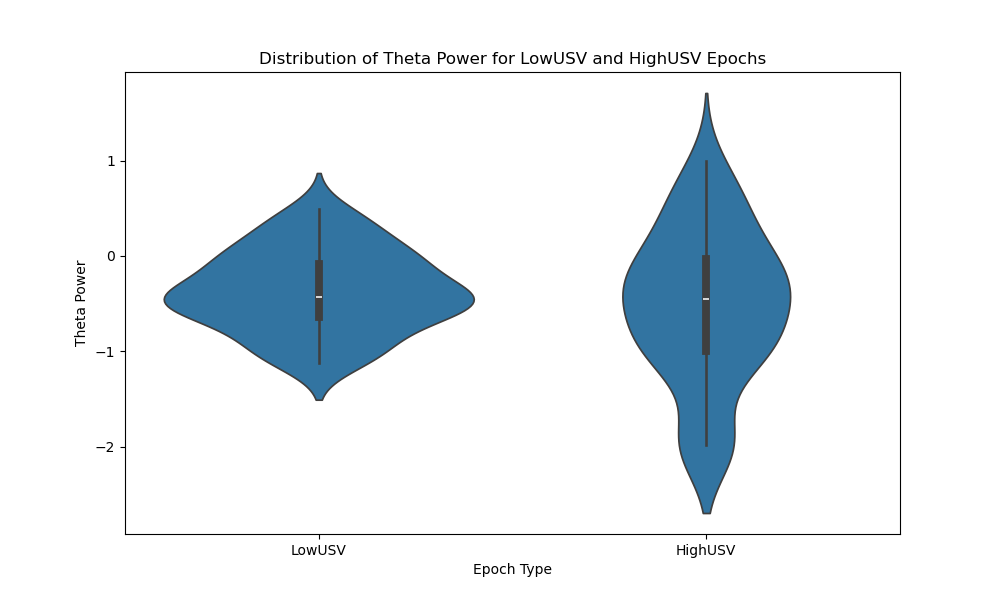

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=theta_power_df, x="Epoch", y="theta Power")

# Adding titles and labels for clarity
plt.title('Distribution of Theta Power for LowUSV and HighUSV Epochs')
plt.xlabel('Epoch Type')
plt.ylabel('Theta Power')

# Save the plot to a file
plt.savefig('/home/bowenw/Documents/thesisplots/theta_power_violin_plot.png')

# Show the plot
plt.show()

In [61]:
usv_epochs

107 epochs
Snippet: 
         start        stop  Begin_Time   Freq_Min  Duration  Freq_Range  Score  \
0  446.819063  446.912341  446.819063  32.435751  0.093278   45.195929    1.0   
1  446.917153  446.991495  446.917153  50.405216  0.074342   34.441476    1.0   
2  447.052188  447.165813  447.052188  43.482818  0.113625   16.668958    1.0   
3  447.256451  447.308525  447.256451  46.914662  0.052074   11.521191    1.0   
4  447.305980  447.444434  447.305980  32.451890  0.138454    9.315006    1.0   

   Accept  nrec  t_start_eeg  t_stop_eeg label  
0       1     2   860.598041  860.691307        
1       1     2   860.696118  860.770450        
2       1     2   860.831136  860.944746        
3       1     2   861.035373  861.087440        
4       1     2   861.084896  861.223332        

## usv/nonusv theta power

In [62]:
recording_duration = 3000 
theta_power_usvs = []
theta_power_non_usvs = []

for i, usv_epoch in enumerate(usv_epochs):
    # Vectorized comparison to check if any t_stop_eeg value exceeds recording_duration
    exceed_indices = usv_epoch._epochs.t_stop_eeg > recording_duration
    
    # Vectorized assignment to adjust those t_stop_eeg values
    usv_epoch._epochs.loc[exceed_indices, 't_stop_eeg'] = recording_duration

    # Assuming usv_epoch._epochs is a DataFrame and t_start_eeg, t_stop_eeg are its columns
    t_start = usv_epoch._epochs.t_start_eeg.iloc[0]  # Assuming you're working with the first row
    t_stop = min(usv_epoch._epochs.t_stop_eeg.iloc[0], recording_duration)

    # Slice theta power using adjusted start and stop times
    power_slice = theta_power_sg.time_slice(t_start=t_start, t_stop=t_stop)
    theta_power_usvs.append(power_slice.traces[0].mean())

    # Preparing for the next start comparison, handling the last epoch separately
    if i + 1 < len(usv_epochs):
        next_start = usv_epochs[i + 1]._epochs.t_start_eeg.iloc[0]
    else:
        next_start = recording_duration  # Default to recording_duration for the last epoch

    # Interval check and theta power calculation for non-USVs
    if t_stop < next_start and (next_start - t_stop) > 1:
        power_slice = theta_power_sg.time_slice(t_start=t_stop, t_stop=next_start)
        theta_power_non_usvs.append(power_slice.traces[0].mean())

# Convert lists to numpy arrays
theta_power_usvs = np.array(theta_power_usvs)
theta_power_non_usvs = np.array(theta_power_non_usvs)

# Create DataFrames and concatenate
df1 = pd.DataFrame({"Theta Power": theta_power_usvs, "Epoch": "USV"})
df2 = pd.DataFrame({"Theta Power": theta_power_non_usvs, "Epoch": "non-USV"})
theta_power_df = pd.concat([df1, df2], axis=0).reset_index(drop=True)

theta_power_df

Theta Power    Epoch
0      -1.979576      USV
1      -1.979576      USV
2      -1.979576      USV
3      -1.979576      USV
4      -1.979576      USV
..           ...      ...
130    -0.071330  non-USV
131    -0.310185  non-USV
132    -0.376829  non-USV
133    -0.184790  non-USV
134    -0.246745  non-USV

[135 rows x 2 columns]

In [63]:
# Make above into pandas DataFrame for easy plotting with seaborn

df1 = pd.DataFrame({"Theta Power": theta_power_usvs, "Epoch": "USV"})
df2 = pd.DataFrame({"Theta Power": theta_power_non_usvs, "Epoch": "non-USV"})
theta_power_df = pd.concat((df1, df2), axis=0).reset_index()
theta_power_df

index  Theta Power    Epoch
0        0    -1.979576      USV
1        1    -1.979576      USV
2        2    -1.979576      USV
3        3    -1.979576      USV
4        4    -1.979576      USV
..     ...          ...      ...
130     23    -0.071330  non-USV
131     24    -0.310185  non-USV
132     25    -0.376829  non-USV
133     26    -0.184790  non-USV
134     27    -0.246745  non-USV

[135 rows x 3 columns]

In [64]:
theta_power_usvs

array([-1.97957609e+00, -1.97957609e+00, -1.97957609e+00, -1.97957609e+00,
       -1.97957609e+00, -3.57749497e-01, -3.35218212e-01,  3.80193018e-01,
       -5.26335101e-01, -4.31259772e-01, -9.00548894e-01,  9.92541993e-01,
        1.72859671e-01,  4.79559366e-01, -9.80722835e-01,  2.43539908e-01,
        5.24463468e-01, -1.13725769e-01, -1.52954645e-01, -5.35291570e-01,
       -7.96047653e-01, -2.96868761e-01, -1.34573675e+00, -8.43711503e-01,
       -4.46251669e-02, -9.81147538e-02, -8.54825186e-01, -1.69406842e-01,
       -3.41582282e-01, -1.10156846e+00, -9.97515192e-01, -3.71836447e-01,
        1.07751643e-03,  5.97942372e-01,  8.02207965e-01,  3.85332950e-01,
        1.16562079e-01,  6.51702732e-01, -4.68632438e-01, -4.90122718e-01,
       -1.16614595e+00, -9.50349356e-01, -4.35132892e-01, -4.75408685e-01,
        8.01234312e-01, -3.49243353e-01, -2.74631813e-01, -3.24228601e-01,
       -3.13182214e-01, -8.43197082e-01, -3.62114195e-01, -5.70015807e-01,
       -4.80144081e-01, -

In [65]:
theta_power_non_usvs.mean()

-0.32895128943553453

In [66]:
# # Easily plot with seaborn
# _, ax = plt.subplots()

# sns.violinplot(data=theta_power_df, x="Epoch", y="Theta Power")

In [67]:
# recording_duration = 3000 
# theta_power_usvs = []
# theta_power_non_usvs = []

# for i, usv_epoch in enumerate(usv_epochs):
#     if usv_epoch.stops > recording_duration:

#         usv_epoch.stops = recording_duration
    

#     power_slice = theta_power_sg.time_slice(t_start=usv_epoch.starts, t_stop=min(usv_epoch.stops, recording_duration))
#     theta_power_usvs.append(power_slice.traces[0].mean())


#     next_start = usv_epochs[i+1].starts if i+1 < len(usv_epochs) else recording_duration

#     if usv_epoch.stops < next_start and (next_start - usv_epoch.stops) > 1:
#         power_slice = theta_power_sg.time_slice(t_start=usv_epoch.stops, t_stop=next_start)
#         theta_power_non_usvs.append(power_slice.traces[0].mean())


# theta_power_usvs = np.array(theta_power_usvs)
# theta_power_non_usvs = np.array(theta_power_non_usvs)


# df1 = pd.DataFrame({"Theta Power": theta_power_usvs, "Epoch": "USV"})
# df2 = pd.DataFrame({"Theta Power": theta_power_non_usvs, "Epoch": "non-USV"})
# theta_power_df = pd.concat([df1, df2], axis=0).reset_index(drop=True)

# theta_power_df

<Axes: title={'center': 'Han: Theta power during usv and non_usv\nMean USV: -0.45, Mean non-USV: -0.33'}, xlabel='Epoch', ylabel='Theta Power'>

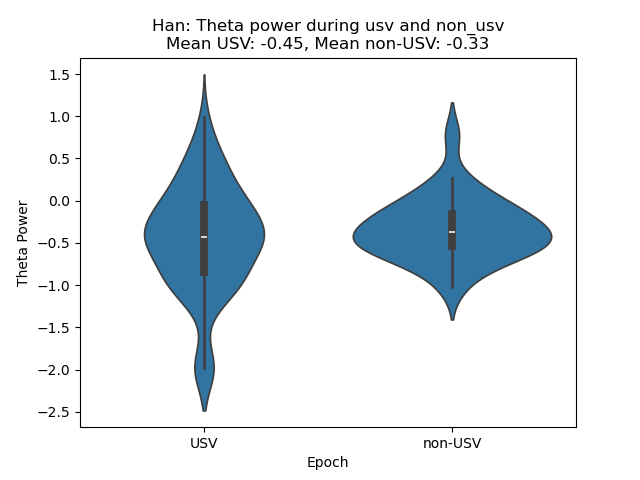

In [68]:
# Easily plot with seaborn
_, ax = plt.subplots()
title_text = f"Han: Theta power during usv and non_usv\nMean USV: {theta_power_usvs.mean():.2f}, Mean non-USV: {theta_power_non_usvs.mean():.2f}"
ax.set_title(title_text)
sns.violinplot(data=theta_power_df, x="Epoch", y="Theta Power")

## Read in frz data

In [69]:
import neuropy.io.dlcio as dlcio
dlc_path = '/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training'
arena_side_pix = 60  # Keep this
arena_side_cm = 25.4  # Update this after measuring!!!
pix2cm = arena_side_cm / arena_side_pix

# Read in DLC data
sess.dlc = dlcio.DLC(dlc_path, pix2cm=pix2cm)

# Smooth position, get timestamps, and get speed
sess.dlc.get_timestamps('ms_webcam', include_str="2_training")
sess.dlc.smooth_pos(bodyparts=["crown_middle", "back_middle"])
sess.dlc.timestamps["Timestamps"] = sess.dlc.timestamps["Timestamps"].dt.tz_localize("America/Detroit")
sess.dlc.get_all_speed()

Using tracking file #1: /data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/2_training/training/Han/gobears/2022_08_03/12_36_08/My_WebCam/Han_training_combined_movieDLC_resnet50_TraceFC_shockboxFeb28shuffle1_500000.h5
Using tracking file #2: /data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/2_training/training/Han/gobears/2022_08_03/12_56_53/My_WebCam/Han_training_combined_movie2DLC_resnet50_TraceFC_shockboxFeb28shuffle1_500000.h5
Multiple videos found - taking mean sample rate from all videos


back_middle  crown_middle  left_ear  neck_base         nose  \
0              NaN           NaN  0.949496   2.045391     0.514713   
1              NaN           NaN  0.640402   3.409019   947.665678   
2              NaN           NaN  1.364747   1.724073     9.313889   
3              NaN           NaN  1.576331   1.492093     3.701812   
4              NaN           NaN  0.817776   6.712119  1293.656959   
...            ...           ...       ...        ...          ...   
47149          NaN           NaN  1.656170   1.045737     0.801105   
47150          NaN           NaN  1.358740   1.636843     2.992546   
47151          NaN           NaN  1.604366   0.949890     2.634357   
47152          NaN           NaN  2.701421   2.157277     2.666349   
47153          NaN           NaN       NaN        NaN          NaN   

        right_ear  tail_base   tail_end  tail_middle  
0      522.352469   2.309584   2.733619   797.835039  
1      618.566829   0.762817  36.962826   951.034649  
2        5.699983   1.175630   6.141868     8.528459  
3        2.763913   0.732941   3.522559     7.967008  
4      615.051174   3.735422   8.239001   163.852439  
...           ...        ...        ...          ...  
47149    2.077901   2.830298   2.976562     3.469482  
47150    3.484092   2.565242   2.823081   104.019311  
47151    0.372942   1.338121   1.548268    82.753621  
47152    2.432953   0.646449   1.647844     0.444972  
47153         NaN        NaN        NaN          NaN  

[47154 rows x 9 columns]

In [70]:
# Load in openephys times to sync
import neuropy.io.openephysio as oeio
sync_df = oeio.create_sync_df(sess.basepath)
sync_df["Total seconds from start"] = (sync_df["Datetime"] - sync_df["Datetime"][0]).dt.total_seconds()

# sync DLC times to your eeg file
sess.dlc.timestamps["Total seconds from OE start"] = (sess.dlc.timestamps["Timestamps"] - sync_df["Datetime"][0]).dt.total_seconds()
sess.dlc.timestamps["eeg_time"] = np.interp(sess.dlc.timestamps["Total seconds from OE start"], sync_df["Total seconds from start"], 
                                            sync_df["eeg_time"])
sess.dlc.timestamps

start time = 2022-08-03 12:25:29.361157-04:00
start time = 2022-08-03 12:28:50.720333-04:00
start time = 2022-08-03 12:35:21.719327-04:00
start time = 2022-08-03 12:53:02.683128-04:00
start time = 2022-08-03 12:56:48.234187-04:00
start time = 2022-08-03 13:10:55.680961-04:00
start time = 2022-08-03 13:14:13.174881-04:00
start time = 2022-08-03 13:16:44.696588-04:00
start time = 2022-08-03 13:35:23.930035-04:00
start time = 2022-08-03 14:25:45.955674-04:00
start time = 2022-08-03 14:34:34.738770-04:00
start time = 2022-08-03 15:19:53.342091-04:00
start time = 2022-08-03 15:42:32.218764-04:00


Frame Number  Time Stamp (ms)  Buffer Index  \
0                 0              -23             3   
1                 1               29             3   
2                 2               73             2   
3                 3              105             1   
4                 4              153             0   
...             ...              ...           ...   
18031         18031           754001             0   
18032         18032           754043             0   
18033         18033           754081             0   
18034         18034           754129             0   
18035         18035           754168             0   

                            Timestamps  Total seconds from OE start  \
0     2022-08-03 12:36:08.552000-04:00                   639.190843   
1     2022-08-03 12:36:08.604000-04:00                   639.242843   
2     2022-08-03 12:36:08.648000-04:00                   639.286843   
3     2022-08-03 12:36:08.680000-04:00                   639.318843   
4     2022-08-03 12:36:08.728000-04:00                   639.366843   
...                                ...                          ...   
18031 2022-08-03 13:09:27.457000-04:00                  2638.095843   
18032 2022-08-03 13:09:27.499000-04:00                  2638.137843   
18033 2022-08-03 13:09:27.537000-04:00                  2638.175843   
18034 2022-08-03 13:09:27.585000-04:00                  2638.223843   
18035 2022-08-03 13:09:27.624000-04:00                  2638.262843   

          eeg_time  
0       463.771826  
1       463.823826  
2       463.867826  
3       463.899826  
4       463.947826  
...            ...  
18031  2408.159915  
18032  2408.201915  
18033  2408.239915  
18034  2408.287915  
18035  2408.326915  

[47154 rows x 6 columns]

In [71]:
# Last calculate freezing times and plot again to check
frz_thresh = 0.25 # cm/sec  Adjust this to something that looks reasonable!
duration_thresh = 2 # sec, must be below the threshold above for at least that long to be considered freezing
bodypart_use = "crown_middle"
frz_bool = sess.dlc.speed[bodypart_use] < frz_thresh
frz_epochs = Epoch.from_boolean_array(frz_bool, t=sess.dlc.timestamps["eeg_time"])
frz_df = frz_epochs.to_dataframe()
frz_df = frz_df[frz_epochs.durations > duration_thresh]
frz_epochs = Epoch(frz_df)
frz_epochs

90 epochs
Snippet: 
         start        stop  duration label
0  709.002578  712.730574  3.727996  high
1  717.066570  719.250568  2.183998  high
2  904.505380  906.809378  2.303998  high
3  923.744361  926.881358  3.136997  high
4  927.961357  931.193354  3.231997  high

In [72]:
frz_epochs

90 epochs
Snippet: 
         start        stop  duration label
0  709.002578  712.730574  3.727996  high
1  717.066570  719.250568  2.183998  high
2  904.505380  906.809378  2.303998  high
3  923.744361  926.881358  3.136997  high
4  927.961357  931.193354  3.231997  high

## moving speed during highusv/lowusv/frz

In [73]:
# Reset index for both timestamps and speed to ensure alignment
timestamps_reset = sess.dlc.timestamps.reset_index(drop=True)
speed_reset = sess.dlc.speed[bodypart_use].reset_index(drop=True)

# Combine timestamps and speed into a DataFrame
dlc_data = pd.DataFrame({
    'eeg_time': timestamps_reset['eeg_time'],
    'speed': speed_reset
})

# Calculate mean speeds during freezing epochs
mean_speeds_during_freezing = []
for start, end in zip(frz_epochs.starts, frz_epochs.stops):
    epoch_speeds = dlc_data[(dlc_data['eeg_time'] >= start) & (dlc_data['eeg_time'] <= end)]['speed']
    mean_speed = epoch_speeds.mean()
    mean_speeds_during_freezing.append(mean_speed)

# Output the results
mean_speeds_during_freezing

[0.12893457716685738,
 0.10637782643558905,
 0.12295548198783636,
 0.09603480597417346,
 0.08621626063022801,
 0.09522092364329394,
 0.10308146727323324,
 0.1311031728645341,
 0.1027050647501072,
 0.10894508390622228,
 0.11103606883463552,
 0.11432825275832074,
 0.12254050211235251,
 0.09866734241693118,
 0.11109930276965445,
 0.10204258328750292,
 0.11719522181695849,
 0.0931648343143605,
 0.10569056726708212,
 0.09488308183364441,
 0.13619840125760307,
 0.10357962045778095,
 0.09413273604193531,
 0.0786213388553232,
 0.12195242406986677,
 0.08595588297279892,
 0.09169759670280454,
 0.07275790730101671,
 0.09644240521445638,
 0.10791134264404437,
 0.11720088002182086,
 0.09022711047975476,
 0.084872153397657,
 0.11575468676765562,
 0.07023928734581215,
 0.10330873696097582,
 0.10450537505909413,
 0.10972515592150034,
 0.09952034949351918,
 0.10398811561469211,
 0.1077278513649143,
 0.0810341968834561,
 0.0984289291262261,
 0.11968829544440855,
 16.027024606716253,
 0.08171030399883886

In [74]:
timestamps_reset = sess.dlc.timestamps.reset_index(drop=True)
speed_reset = sess.dlc.speed[bodypart_use].reset_index(drop=True)

# Combine timestamps and speed into a DataFrame
dlc_data = pd.DataFrame({
    'eeg_time': timestamps_reset['eeg_time'],
    'speed': speed_reset
})
# Moving speed during high USVs
mean_speeds_during_highusv = []
for start, end in zip(highusv_epochs['t_start_eeg'], highusv_epochs['t_stop_eeg']):
    epoch_speeds = dlc_data[(dlc_data['eeg_time'] >= start) & (dlc_data['eeg_time'] <= end)]['speed']
    mean_speed = epoch_speeds.mean()
    mean_speeds_during_highusv.append(mean_speed)

mean_speeds_during_highusv

[46.806883653868375,
 23.113368902625954,
 9.885736204274055,
 9.004671134645262,
 14.67047516411214,
 15.41697047461041,
 8.094052184195231,
 1.086282466900045,
 0.9610348574139513,
 0.7620662254152567,
 0.5237485449981358,
 2.2444336907692546,
 0.743076930874897,
 2.841799420113348,
 2.3021729861736198,
 2.279301882542369,
 1.6214597227314091,
 0.29902462364980675,
 0.15846717821541575,
 0.5074811262711281,
 0.249500412976092,
 0.4096006710583549,
 0.20639469130717747,
 0.17294603495891833,
 4.5083542965305705,
 0.3828018105228764,
 0.4425314376754662,
 0.06781379288469988,
 0.11044917546364055,
 0.8515407581252077,
 0.949371902940873,
 0.19903032125094167,
 6.039148856703465,
 5.267949127856561,
 6.703435721455596,
 13.525448590994941,
 1.2629013830914375,
 5.8618648022482915,
 2.4663073814646825,
 2.513367539424148,
 0.2842290177182173,
 0.8285749194522587,
 7.536696010401622,
 9.789684760689909,
 0.56922439511916,
 20.42448135509061,
 21.681115007235064,
 0.1609062009975953,
 nan,

In [75]:
timestamps_reset = sess.dlc.timestamps.reset_index(drop=True)
speed_reset = sess.dlc.speed[bodypart_use].reset_index(drop=True)

# Combine timestamps and speed into a DataFrame
dlc_data = pd.DataFrame({
    'eeg_time': timestamps_reset['eeg_time'],
    'speed': speed_reset
})
# Moving speed during low USVs
mean_speeds_during_lowusv = []
for start, end in zip(lowusv_epochs['t_start_eeg'], lowusv_epochs['t_stop_eeg']):
    epoch_speeds = dlc_data[(dlc_data['eeg_time'] >= start) & (dlc_data['eeg_time'] <= end)]['speed']
    mean_speed = epoch_speeds.mean()
    mean_speeds_during_lowusv.append(mean_speed)

mean_speeds_during_lowusv

[1.4854367354100628,
 0.4488094800636352,
 1.0416906353212814,
 0.3696332984724957,
 0.19904674514054008,
 0.547169018735611,
 1.116181832276683,
 0.22280824930560836,
 0.12891854922254456,
 1.12121015243231,
 1.2862011292244078,
 0.3080970086655673,
 0.37066542994783497,
 0.25985222701048344,
 0.29590703652348815,
 0.9209945092260153,
 2.5371405591632943,
 0.6173946269939555,
 25.656296599612812,
 1.7086173600180006,
 4.192891143912211,
 2.0895620020897994,
 5.455354150440677,
 3.078043024116279,
 0.14527010430733012,
 0.48261621968246365,
 0.16621141330790362,
 0.07325280274667438,
 0.044920921642847694,
 17.534199615691353,
 0.8618592208630023,
 1.369236355998779,
 9.043951893543992,
 10.80878752344708,
 7.016047591407943,
 4.117408957793557,
 6.796288242956572,
 7.190072003986181,
 4.0359349726006295,
 2.4009589160633262,
 0.3490026077564616,
 0.3063165648646372,
 0.16563012717802802,
 0.5017232427658835,
 0.30613646328416794,
 1.193297670814838,
 4.063009206679845,
 0.255283663951

## Theta power during usv/nonusv/frz

In [76]:
theta_power_frz = []
theta_power_sg = core.signal.Signal(theta_power, signal.sampling_rate)
for frz_epoch in frz_epochs:

    power_slice = theta_power_sg.time_slice(t_start=frz_epoch.starts, t_stop=frz_epoch.stops)
    theta_power_frz.append(power_slice.traces[0].mean())

theta_power_frz = np.array(theta_power_frz)

frz_df = pd.DataFrame({"Theta Power": theta_power_frz, "Epoch": "Freezing"})
theta_power_df = pd.concat((df1, df2, frz_df), axis=0).reset_index()

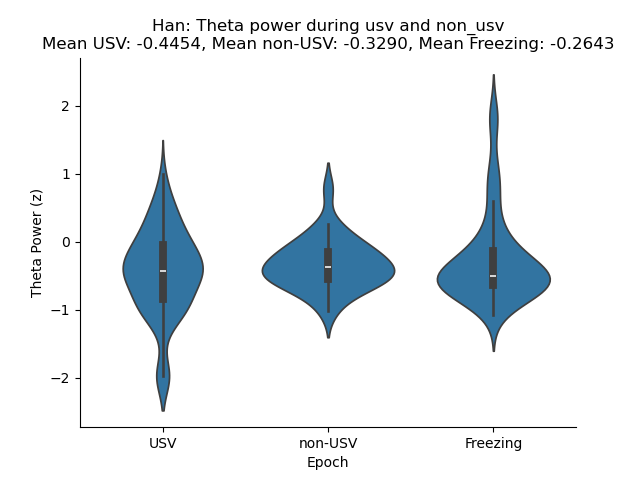

In [77]:
# Easily plot with seaborn
vio2, ax = plt.subplots()

title_text = f"Han: Theta power during usv and non_usv\nMean USV: {theta_power_usvs.mean():.4f}, Mean non-USV: {theta_power_non_usvs.mean():.4f}, Mean Freezing: {theta_power_frz.mean():.4f}"
ax.set_title(title_text)
sns.violinplot(data=theta_power_df, x="Epoch", y="Theta Power")
ax.set_ylabel("Theta Power (z)")
sns.despine(ax=ax)
vio2.savefig('/home/bowenw/Documents/thesisplots/Han usv nonusv thetapower violinplot low high.png')

In [78]:
import pingouin as pg
pg.pairwise_tests(data=theta_power_df, dv="Theta Power", between="Epoch", padjust="bonf")

Contrast         A        B  Paired  Parametric         T         dof  \
0    Epoch  Freezing      USV   False        True  1.962430  188.380020   
1    Epoch  Freezing  non-USV   False        True  0.661074   80.962112   
2    Epoch       USV  non-USV   False        True -1.246660   74.321876   

  alternative     p-unc    p-corr p-adjust   BF10    hedges  
0   two-sided  0.051185  0.153555     bonf  0.931  0.279926  
1   two-sided  0.510442  1.000000     bonf  0.273  0.107813  
2   two-sided  0.216437  0.649311     bonf  0.439 -0.194373

In [79]:
usv_epochs.starts

array([ 446.81906301,  446.91715284,  447.05218771,  447.256451  ,
        447.30598008,  447.7845493 ,  448.28526858,  448.9645811 ,
        449.37150162,  449.751268  ,  450.06869582,  450.64837922,
        451.93130766,  452.68485481,  453.501268  ,  453.82037487,
        453.86169436,  455.34271356,  455.37788224,  455.63277742,
        457.26058559,  457.79817043,  459.151268  ,  459.39743658,
        460.321268  ,  460.761268  ,  462.39643062,  463.87905761,
        463.92017756,  464.83679917,  464.85604677,  465.381268  ,
        466.29278694,  467.1537688 ,  467.21324751,  468.30117815,
        468.88145575,  469.64394224,  470.77588659,  470.80977793,
        471.491268  ,  472.24119837,  472.28212233,  473.73255579,
        474.211268  ,  475.44154703,  475.48244127,  477.281268  ,
        478.90360516,  481.47264731,  483.281268  ,  488.80743658,
        493.601268  ,  494.901268  ,  497.851268  ,  499.10908742,
        504.74044578,  505.991268  ,  512.55128434,  513.81991

In [80]:
frz_df

Theta Power     Epoch
0      1.852433  Freezing
1      1.781019  Freezing
2     -0.570467  Freezing
3     -0.499698  Freezing
4     -0.926168  Freezing
..          ...       ...
85    -1.021888  Freezing
86    -0.601599  Freezing
87    -0.470159  Freezing
88    -0.668261  Freezing
89    -0.047983  Freezing

[90 rows x 2 columns]

## theta power during USV/frz/USV during frz/USV during nonfrz

In [81]:
def categorize_usvs(usv_df, frz_df):
    usvs_during_freezing = []
    usvs_non_overlap = []
    for index, usv in usv_df.iterrows():
        overlap = False
        for _, frz in frz_df.iterrows():
            if (usv['start'] < frz['stop']) and (usv['stop'] > frz['start']):
                overlap = True
                usvs_during_freezing.append(usv)
                break
        if not overlap:
            usvs_non_overlap.append(usv)
    return pd.DataFrame(usvs_during_freezing), pd.DataFrame(usvs_non_overlap)

# Calculate the mean theta power for a given epoch type
def calculate_theta_power(signal, epochs_df):
    theta_power_values = []
    for _, epoch in epochs_df.iterrows():
        power_slice = signal.time_slice(t_start=epoch['start'], t_stop=epoch['stop'])
        theta_power_values.append(power_slice.traces[0].mean())
    return np.array(theta_power_values)

# Convert Epoch objects to DataFrames
usv_df = usv_epochs.to_dataframe()
frz_df = frz_epochs.to_dataframe()


### Replace start and stop with t_eeg_start/stop

In [82]:
usv_df
df = pd.DataFrame(usv_df)

# Replace all values of "start" and "stop" with "t_start_eeg" and "t_stop_eeg"
df['start'] = df['t_start_eeg']
df['stop'] = df['t_stop_eeg']
usv_df

start         stop   Begin_Time   Freq_Min  Duration  Freq_Range  \
0     860.598041   860.691307   446.819063  32.435751  0.093278   45.195929   
1     860.696118   860.770450   446.917153  50.405216  0.074342   34.441476   
2     860.831136   860.944746   447.052188  43.482818  0.113625   16.668958   
3     861.035373   861.087440   447.256451  46.914662  0.052074   11.521191   
4     861.084896   861.223332   447.305980  32.451890  0.138454    9.315006   
..           ...          ...          ...        ...       ...         ...   
102  1624.587944  1625.214228  1248.889305  14.512427  0.626377    7.111111   
103  1625.300156  1625.794220  1249.601622  14.055556  0.494137    7.777778   
104  1625.886424  1626.518784  1250.187977  13.728436  0.632454    8.777778   
105  1626.619202  1627.160008  1250.920864  15.388889  0.540886    7.000000   
106  1858.644967  1858.734567  1499.050434  31.755089  0.089614   37.708651   

        Score  Accept  nrec  t_start_eeg   t_stop_eeg label  duration  
0    1.000000       1     2   860.598041   860.691307        0.093278  
1    1.000000       1     2   860.696118   860.770450        0.074342  
2    1.000000       1     2   860.831136   860.944746        0.113625  
3    1.000000       1     2   861.035373   861.087440        0.052074  
4    1.000000       1     2   861.084896   861.223332        0.138454  
..        ...     ...   ...          ...          ...   ...       ...  
102  1.000000       1     3  1624.587944  1625.214228        0.626377  
103  1.000000       1     3  1625.300156  1625.794220        0.494137  
104  1.000000       1     3  1625.886424  1626.518784        0.632454  
105  1.000000       1     3  1626.619202  1627.160008        0.540886  
106  0.552402       1     4  1858.644967  1858.734567        0.089614  

[107 rows x 13 columns]

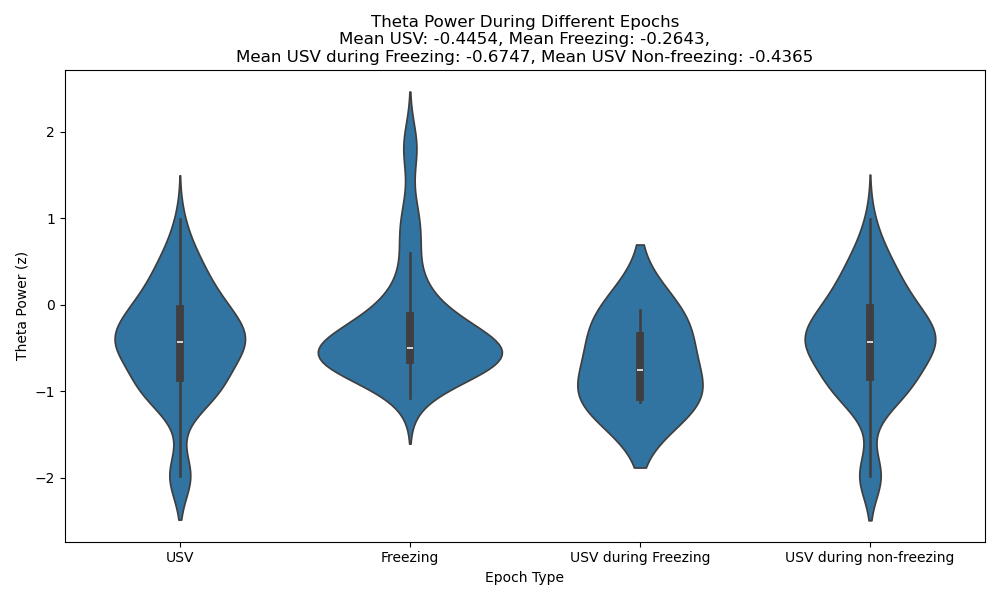

In [83]:
# Categorize USVs
usv_during_freezing_df, usv_non_overlap_df = categorize_usvs(usv_df, frz_df)

# Assuming theta_power_sg is already correctly instantiated:
# Calculate theta power for each epoch type
theta_power_usv = theta_power_usvs
theta_power_frz = theta_power_frz
theta_power_usv_during_freezing = calculate_theta_power(theta_power_sg, usv_during_freezing_df)
theta_power_usv_non_overlap = calculate_theta_power(theta_power_sg, usv_non_overlap_df)

# Create DataFrame for plotting
df_usv = pd.DataFrame({"Theta Power": theta_power_usv, "Epoch": "USV"})
df_frz = pd.DataFrame({"Theta Power": theta_power_frz, "Epoch": "Freezing"})
df_usv_during_freezing = pd.DataFrame({"Theta Power": theta_power_usv_during_freezing, "Epoch": "USV during Freezing"})
df_usv_non_overlap = pd.DataFrame({"Theta Power": theta_power_usv_non_overlap, "Epoch": "USV during non-freezing"})

theta_power_df = pd.concat([df_usv, df_frz, df_usv_during_freezing, df_usv_non_overlap]).reset_index(drop=True)

mean_theta_power_usv = theta_power_usv.mean()
mean_theta_power_frz = theta_power_frz.mean()
mean_theta_power_usv_during_freezing = theta_power_usv_during_freezing.mean()
mean_theta_power_usv_non_freezing = theta_power_usv_non_overlap.mean()



title_text = (
    f"Theta Power During Different Epochs\n"
    f"Mean USV: {mean_theta_power_usv:.4f}, "
    f"Mean Freezing: {mean_theta_power_frz:.4f},\n"
    f"Mean USV during Freezing: {mean_theta_power_usv_during_freezing:.4f}, "
    f"Mean USV Non-freezing: {mean_theta_power_usv_non_freezing:.4f}"
)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(data=theta_power_df, x="Epoch", y="Theta Power")
plt.title(title_text)
plt.xlabel("Epoch Type")
plt.ylabel("Theta Power (z)")
plt.tight_layout()
plt.show()

In [84]:
usv_during_freezing_df

start         stop  Begin_Time   Freq_Min  Duration  Freq_Range  \
58   926.321870   927.488412  512.551284  15.016453  1.166690   11.833333   
59   927.590340   928.123789  513.819916  14.000000  0.533517   11.097938   
80  1397.751072  1398.430121  984.040678  15.388889  0.679136    6.666667   
81  1398.525037  1399.070445  984.814742  14.500000  0.545478    7.333333   

       Score  Accept  nrec  t_start_eeg   t_stop_eeg label  duration  
58  0.564642       1     2   926.321870   927.488412        1.166690  
59  0.564642       1     2   927.590340   928.123789        0.533517  
80  1.000000       1     2  1397.751072  1398.430121        0.679136  
81  1.000000       1     2  1398.525037  1399.070445        0.545478

In [85]:
usv_df

start         stop   Begin_Time   Freq_Min  Duration  Freq_Range  \
0     860.598041   860.691307   446.819063  32.435751  0.093278   45.195929   
1     860.696118   860.770450   446.917153  50.405216  0.074342   34.441476   
2     860.831136   860.944746   447.052188  43.482818  0.113625   16.668958   
3     861.035373   861.087440   447.256451  46.914662  0.052074   11.521191   
4     861.084896   861.223332   447.305980  32.451890  0.138454    9.315006   
..           ...          ...          ...        ...       ...         ...   
102  1624.587944  1625.214228  1248.889305  14.512427  0.626377    7.111111   
103  1625.300156  1625.794220  1249.601622  14.055556  0.494137    7.777778   
104  1625.886424  1626.518784  1250.187977  13.728436  0.632454    8.777778   
105  1626.619202  1627.160008  1250.920864  15.388889  0.540886    7.000000   
106  1858.644967  1858.734567  1499.050434  31.755089  0.089614   37.708651   

        Score  Accept  nrec  t_start_eeg   t_stop_eeg label  duration  
0    1.000000       1     2   860.598041   860.691307        0.093278  
1    1.000000       1     2   860.696118   860.770450        0.074342  
2    1.000000       1     2   860.831136   860.944746        0.113625  
3    1.000000       1     2   861.035373   861.087440        0.052074  
4    1.000000       1     2   861.084896   861.223332        0.138454  
..        ...     ...   ...          ...          ...   ...       ...  
102  1.000000       1     3  1624.587944  1625.214228        0.626377  
103  1.000000       1     3  1625.300156  1625.794220        0.494137  
104  1.000000       1     3  1625.886424  1626.518784        0.632454  
105  1.000000       1     3  1626.619202  1627.160008        0.540886  
106  0.552402       1     4  1858.644967  1858.734567        0.089614  

[107 rows x 13 columns]

In [86]:
usv_df

start         stop   Begin_Time   Freq_Min  Duration  Freq_Range  \
0     860.598041   860.691307   446.819063  32.435751  0.093278   45.195929   
1     860.696118   860.770450   446.917153  50.405216  0.074342   34.441476   
2     860.831136   860.944746   447.052188  43.482818  0.113625   16.668958   
3     861.035373   861.087440   447.256451  46.914662  0.052074   11.521191   
4     861.084896   861.223332   447.305980  32.451890  0.138454    9.315006   
..           ...          ...          ...        ...       ...         ...   
102  1624.587944  1625.214228  1248.889305  14.512427  0.626377    7.111111   
103  1625.300156  1625.794220  1249.601622  14.055556  0.494137    7.777778   
104  1625.886424  1626.518784  1250.187977  13.728436  0.632454    8.777778   
105  1626.619202  1627.160008  1250.920864  15.388889  0.540886    7.000000   
106  1858.644967  1858.734567  1499.050434  31.755089  0.089614   37.708651   

        Score  Accept  nrec  t_start_eeg   t_stop_eeg label  duration  
0    1.000000       1     2   860.598041   860.691307        0.093278  
1    1.000000       1     2   860.696118   860.770450        0.074342  
2    1.000000       1     2   860.831136   860.944746        0.113625  
3    1.000000       1     2   861.035373   861.087440        0.052074  
4    1.000000       1     2   861.084896   861.223332        0.138454  
..        ...     ...   ...          ...          ...   ...       ...  
102  1.000000       1     3  1624.587944  1625.214228        0.626377  
103  1.000000       1     3  1625.300156  1625.794220        0.494137  
104  1.000000       1     3  1625.886424  1626.518784        0.632454  
105  1.000000       1     3  1626.619202  1627.160008        0.540886  
106  0.552402       1     4  1858.644967  1858.734567        0.089614  

[107 rows x 13 columns]

In [87]:
mean_theta_power_usv_non_freezing

-0.4365200272163535

## Ripple power

In [88]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 8
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
exclude_theta_epochs = False  # make this true if you end up with a lot of false positive ripples as gamma events during theta

if not exclude_theta_epochs:
    ripple_epochs, ripple_power = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    ripple_epochs, ripple_power = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff,
                                         ignore_epochs=art_epochs.__add__(theta_epochs), return_power=True)
sess.recinfo.write_epochs(ripple_epochs, ext='swr')
ripple_epochs_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
ripple_epochs.save(ripple_epochs_file)

Selected channels for ripples: [8]
8013 epochs remaining with durations within (0.05,0.45)
/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training.ripple_epochs.npy saved


In [89]:
signal.time_slice(t_start=usv_epochs.starts[0], t_stop=usv_epochs.stops[0])

In [90]:
ripple_power_sg = core.signal.Signal(ripple_power, signal.sampling_rate)

In [91]:
signal.time_slice(t_start=usv_epochs.starts[0], t_stop=usv_epochs.stops[0])
ripple_power_sg = core.signal.Signal(ripple_power, signal.sampling_rate)
ripple_power_usvs, ripple_power_non_usvs = [], []
ripple_power_sg = core.signal.Signal(ripple_power, signal.sampling_rate)
for usv_epoch, usv_next_epoch in zip(usv_epochs, usv_epochs[1:]):

    power_slice = ripple_power_sg.time_slice(t_start=usv_epoch.starts, t_stop=usv_epoch.stops)
    ripple_power_usvs.append(power_slice.traces[0].mean())

    power_slice = ripple_power_sg.time_slice(t_start=usv_epoch.starts, t_stop=usv_next_epoch.starts)
    ripple_power_non_usvs.append(power_slice.traces[0].mean())

ripple_power_usvs = np.array(ripple_power_usvs)
ripple_power_non_usvs = np.array(ripple_power_non_usvs)

In [92]:
ripple_power_usvs.mean()

0.5614357592867913

In [93]:
ripple_power_non_usvs.mean()

0.5745670248570367

In [94]:
usv_epochs

107 epochs
Snippet: 
         start        stop  Begin_Time   Freq_Min  Duration  Freq_Range  Score  \
0  446.819063  446.912341  446.819063  32.435751  0.093278   45.195929    1.0   
1  446.917153  446.991495  446.917153  50.405216  0.074342   34.441476    1.0   
2  447.052188  447.165813  447.052188  43.482818  0.113625   16.668958    1.0   
3  447.256451  447.308525  447.256451  46.914662  0.052074   11.521191    1.0   
4  447.305980  447.444434  447.305980  32.451890  0.138454    9.315006    1.0   

   Accept  nrec  t_start_eeg  t_stop_eeg label  
0       1     2   860.598041  860.691307        
1       1     2   860.696118  860.770450        
2       1     2   860.831136  860.944746        
3       1     2   861.035373  861.087440        
4       1     2   861.084896  861.223332        

In [95]:
recording_duration = 3000 
ripple_power_usvs = []
ripple_power_non_usvs = []

for i, usv_epoch in enumerate(usv_epochs):
    # Vectorized comparison to check if any t_stop_eeg value exceeds recording_duration
    exceed_indices = usv_epoch._epochs.t_stop_eeg > recording_duration
    
    # Vectorized assignment to adjust those t_stop_eeg values
    usv_epoch._epochs.loc[exceed_indices, 't_stop_eeg'] = recording_duration

    # Assuming usv_epoch._epochs is a DataFrame and t_start_eeg, t_stop_eeg are its columns
    t_start = usv_epoch._epochs.t_start_eeg.iloc[0]  # Assuming you're working with the first row
    t_stop = min(usv_epoch._epochs.t_stop_eeg.iloc[0], recording_duration)

    # Slice ripple power using adjusted start and stop times
    power_slice = ripple_power_sg.time_slice(t_start=t_start, t_stop=t_stop)
    ripple_power_usvs.append(power_slice.traces[0].mean())

    # Preparing for the next start comparison, handling the last epoch separately
    if i + 1 < len(usv_epochs):
        next_start = usv_epochs[i + 1]._epochs.t_start_eeg.iloc[0]
    else:
        next_start = recording_duration  # Default to recording_duration for the last epoch

    # Interval check and ripple power calculation for non-USVs
    if t_stop < next_start and (next_start - t_stop) > 1:
        power_slice = ripple_power_sg.time_slice(t_start=t_stop, t_stop=next_start)
        ripple_power_non_usvs.append(power_slice.traces[0].mean())

# Convert lists to numpy arrays
ripple_power_usvs = np.array(ripple_power_usvs)
ripple_power_non_usvs = np.array(ripple_power_non_usvs)

# Create DataFrames and concatenate
df1 = pd.DataFrame({"Ripple Power": ripple_power_usvs, "Epoch": "USV"})
df2 = pd.DataFrame({"Ripple Power": ripple_power_non_usvs, "Epoch": "non-USV"})
ripple_power_df = pd.concat([df1, df2], axis=0).reset_index(drop=True)

ripple_power_df

Ripple Power    Epoch
0       -2.359413      USV
1       -2.359413      USV
2       -2.359413      USV
3       -2.359413      USV
4       -2.359413      USV
..            ...      ...
130      5.561701  non-USV
131      0.257593  non-USV
132      3.105060  non-USV
133      0.259496  non-USV
134      0.160028  non-USV

[135 rows x 2 columns]

<Axes: title={'center': 'Han: Ripple Power during USV and Non-USV\nMean USV: 1.6716, Mean non-USV: 0.7393'}, xlabel='Epoch', ylabel='Ripple Power'>

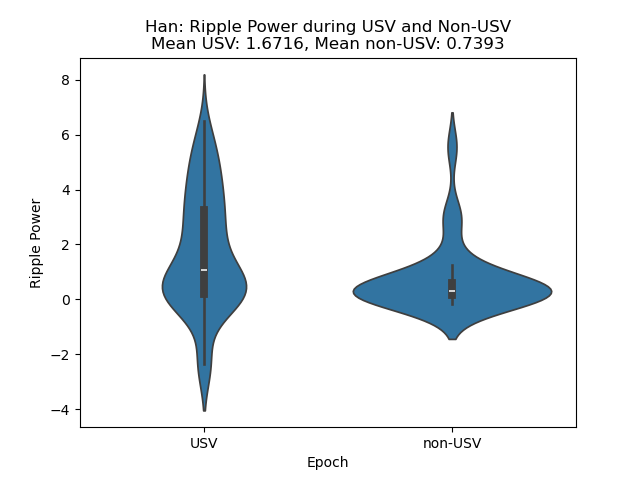

In [96]:
_, ax = plt.subplots()
title_text = f"Han: Ripple Power during USV and Non-USV\nMean USV: {ripple_power_usvs.mean():.4f}, Mean non-USV: {ripple_power_non_usvs.mean():.4f}"
ax.set_title(title_text)
sns.violinplot(data=ripple_power_df, x="Epoch", y="Ripple Power", ax=ax)


## Ripple power during usv/nonusv/frz

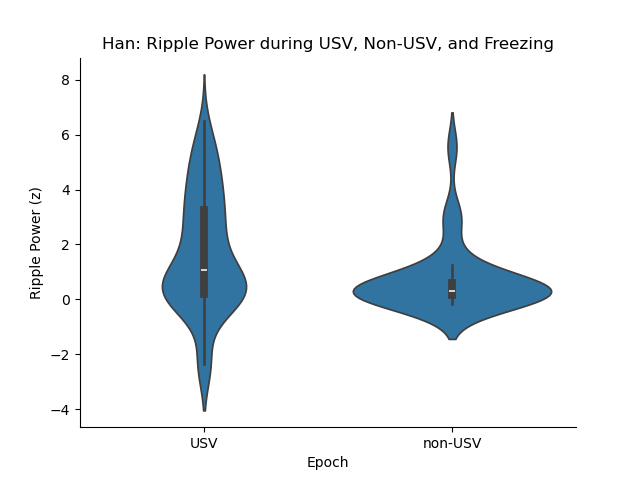

In [97]:
fig, ax = plt.subplots()
title_text = "Han: Ripple Power during USV, Non-USV, and Freezing"
ax.set_title(title_text)
sns.violinplot(data=ripple_power_df, x="Epoch", y="Ripple Power", ax=ax)
ax.set_ylabel("Ripple Power (z)")
sns.despine(ax=ax)
plt.show()

In [103]:
ripple_power_frz = []
ripple_power_sg = core.signal.Signal(ripple_power, signal.sampling_rate)
for frz_epoch in frz_epochs:

    power_slice = ripple_power_sg.time_slice(t_start=frz_epoch.starts, t_stop=frz_epoch.stops)
    ripple_power_frz.append(power_slice.traces[0].mean())

ripple_power_frz = np.array(ripple_power_frz)

frz_df = pd.DataFrame({"Ripple Power": ripple_power_frz, "Epoch": "Freezing"})
ripple_power_df = pd.concat((df1, df2, frz_df), axis=0).reset_index()

In [102]:
ripple_power_df

index  Ripple Power     Epoch  ripple Power
0        0     -2.359413       USV           NaN
1        1     -2.359413       USV           NaN
2        2     -2.359413       USV           NaN
3        3     -2.359413       USV           NaN
4        4     -2.359413       USV           NaN
..     ...           ...       ...           ...
220     85           NaN  Freezing     -0.275001
221     86           NaN  Freezing     -0.283317
222     87           NaN  Freezing     -0.007131
223     88           NaN  Freezing     -0.183024
224     89           NaN  Freezing      0.256761

[225 rows x 4 columns]

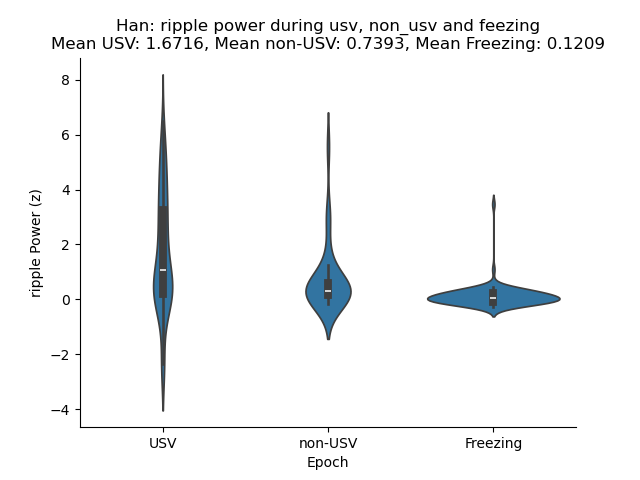

In [104]:
# Easily plot with seaborn
vio1, ax = plt.subplots()

title_text = f"Han: ripple power during usv, non_usv and feezing\nMean USV: {ripple_power_usvs.mean():.4f}, Mean non-USV: {ripple_power_non_usvs.mean():.4f}, Mean Freezing: {ripple_power_frz.mean():.4f}"
ax.set_title(title_text)
sns.violinplot(data=ripple_power_df, x="Epoch", y="Ripple Power")
ax.set_ylabel("ripple Power (z)")
sns.despine(ax=ax)
vio1.savefig('/home/bowenw/Documents/thesisplots/Han usv nonusv ripplepower violinplot1.png')

In [105]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# vio1j, ax = plt.subplots()
# title_text = f"Han: Ripple Power during USV, Non-USV, and Freezing\nMean USV: {ripple_power_usvs.mean():.4f}, Mean non-USV: {ripple_power_non_usvs.mean():.4f}, Mean Freezing: {ripple_power_frz.mean():.4f}"
# ax.set_title(title_text)
# sns.violinplot(data=ripple_power_df, x="Epoch", y="Ripple Power", ax=ax)  
# ax.set_ylabel("Ripple Power (z)")  
# sns.despine(ax=ax)
# vio1j.savefig('/home/bowenw/Documents/thesisplots/Han usv nonusv ripplepower violinplot2.png')

In [101]:
import pingouin as pgb
pg.pairwise_tests(data=ripple_power_df, dv="ripple Power", between="Epoch", padjust="bonf"')

SyntaxError: unterminated string literal (detected at line 2) (2171571666.py, line 2)

## Lowusv/highusv ripple power

In [ ]:
import numpy as np
import pandas as pd

recording_duration = 3000

ripple_power_highusvs = []
ripple_power_lowusvs = []

for i, usv_epoch in enumerate(usv_epochs):
    # Vectorized operation to adjust t_stop_eeg values exceeding recording_duration
    usv_epoch._epochs.loc[usv_epoch._epochs.t_stop_eeg > recording_duration, 't_stop_eeg'] = recording_duration

    freq_min = usv_epoch.to_dataframe()['Freq_Min'].values[0]  # Assuming this produces a scalar; adjust if it's not the case

    # For high frequency USVs
    if freq_min > 23:
        t_start = usv_epoch._epochs.t_start_eeg.iloc[0]  # Use iloc to safely select the first element
        t_stop = min(usv_epoch._epochs.t_stop_eeg.iloc[0], recording_duration)
        power_slice = ripple_power_sg.time_slice(t_start=t_start, t_stop=t_stop)
        ripple_power_highusvs.append(power_slice.traces[0].mean())
        
    # For low frequency USVs
    elif freq_min <= 23:
        t_start = usv_epoch._epochs.t_start_eeg.iloc[0]
        t_stop = min(usv_epoch._epochs.t_stop_eeg.iloc[0], recording_duration)
        power_slice = ripple_power_sg.time_slice(t_start=t_start, t_stop=t_stop)
        ripple_power_lowusvs.append(power_slice.traces[0].mean())

# Convert to numpy arrays for analysis
ripple_power_lowusvs = np.array(ripple_power_lowusvs)
ripple_power_highusvs = np.array(ripple_power_highusvs)

# Creating DataFrame for plotting
df2 = pd.DataFrame({"Ripple Power": ripple_power_lowusvs, "Epoch": "LowUSV"})
df3 = pd.DataFrame({"Ripple Power": ripple_power_highusvs, "Epoch": "HighUSV"})
ripple_power_df = pd.concat([df2, df3], axis=0).reset_index(drop=True)

ripple_power_df

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

vio3, ax = plt.subplots()
title_text = f"Han: Mean LowUSV: {ripple_power_lowusvs.mean():.4f}, Mean HighUSV: {ripple_power_highusvs.mean():.4f}"
ax.set_title(title_text)
# Make sure the column name exactly matches your DataFrame's column name
sns.violinplot(data=ripple_power_df, x="Epoch", y="Ripple Power", ax=ax)
ax.set_ylabel("Ripple Power (z)")
sns.despine(ax=ax)
vio3.savefig('/home/bowenw/Documents/thesisplots/Han usv nonusv ripplepower violinplot low high ONLY.png')

In [ ]:
ripple_power_usvs

In [ ]:
ripple_power_non_usvs

In [ ]:
ripple_power_frz

## ripple power during USV/frz/USV during frz/USV during nonfrz

In [ ]:
def categorize_usvs(usv_df, frz_df):
    usvs_during_freezing = []
    usvs_non_overlap = []
    for index, usv in usv_df.iterrows():
        overlap = False
        for _, frz in frz_df.iterrows():
            if (usv['start'] < frz['stop']) and (usv['stop'] > frz['start']):
                overlap = True
                usvs_during_freezing.append(usv)
                break
        if not overlap:
            usvs_non_overlap.append(usv)
    return pd.DataFrame(usvs_during_freezing), pd.DataFrame(usvs_non_overlap)

# Calculate the mean ripple power for a given epoch type
def calculate_ripple_power(signal, epochs_df):
    ripple_power_values = []
    for _, epoch in epochs_df.iterrows():
        power_slice = signal.time_slice(t_start=epoch['start'], t_stop=epoch['stop'])
        ripple_power_values.append(power_slice.traces[0].mean())
    return np.array(ripple_power_values)

# Convert Epoch objects to DataFrames
usv_df = usv_epochs.to_dataframe()
frz_df = frz_epochs.to_dataframe()

# Categorize USVs
usv_during_freezing_df, usv_non_overlap_df = categorize_usvs(usv_df, frz_df)

# Assuming ripple_power_sg is already correctly instantiated:
# Calculate ripple power for each epoch type
ripple_power_usv = ripple_power_usvs
ripple_power_frz = calculate_ripple_power(ripple_power_sg, frz_df)
ripple_power_usv_during_freezing = calculate_ripple_power(ripple_power_sg, usv_during_freezing_df)
ripple_power_usv_non_overlap = calculate_ripple_power(ripple_power_sg, usv_non_overlap_df)

# Create DataFrame for plotting
df_usv = pd.DataFrame({"ripple Power": ripple_power_usv, "Epoch": "USV"})
df_frz = pd.DataFrame({"ripple Power": ripple_power_frz, "Epoch": "Freezing"})
df_usv_during_freezing = pd.DataFrame({"ripple Power": ripple_power_usv_during_freezing, "Epoch": "USV during Freezing"})
df_usv_non_overlap = pd.DataFrame({"ripple Power": ripple_power_usv_non_overlap, "Epoch": "USV during non-freezing"})

ripple_power_df = pd.concat([df_usv, df_frz, df_usv_during_freezing, df_usv_non_overlap]).reset_index(drop=True)

mean_ripple_power_usv = ripple_power_usv.mean()
mean_ripple_power_frz = ripple_power_frz.mean()
mean_ripple_power_usv_during_freezing = ripple_power_usv_during_freezing.mean()
mean_ripple_power_usv_non_freezing = ripple_power_usv_non_overlap.mean()



title_text = (
    f"ripple Power During Different Epochs\n"
    f"Mean USV: {mean_ripple_power_usv:.4f}, "
    f"Mean Freezing: {mean_ripple_power_frz:.4f},\n"
    f"Mean USV during Freezing: {mean_ripple_power_usv_during_freezing:.4f}, "
    f"Mean USV Non-freezing: {mean_ripple_power_usv_non_freezing:.4f}"
)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(data=ripple_power_df, x="Epoch", y="ripple Power")
plt.title(title_text)
plt.xlabel("Epoch Type")
plt.ylabel("ripple Power (z)")
plt.tight_layout()
plt.show()

In [ ]:
df_usv_during_freezing

In [ ]:
df_usv

In [ ]:
frz_epochs